# Process 10x data

**Author:** William Colgan <br>
**Date:** June 19 2024 <br>
**Enviromnent:** py10-env <br>
**Experiment:** 4T1_barcoding <br>

## Purpose

This notebook processes 10x scRNA-seq data from a lineage tracing experiment. It calls clones based on shared target sites and identifies doublet and low quality cells. It also processes target site reads, filtering out alleles with insufficient coverage, removing target sites with multiple integrations, and finally assigning a unique target site allele to each cell.

## Setup

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pycea
import scanpy as sc
import anndata as ad
import treedata as td
import networkx as nx
import pycea
import numpy as np
import multiprocessing as mp
from sklearn.decomposition import NMF
from sklearn.cluster import SpectralClustering
from pathlib import Path
import sys

Configure paths

In [2]:
base_path = Path("/lab/solexa_weissman/PEtracing_shared/PETracer_Paper/")
data_path = base_path / "barcoding" / "data"
reference_path = base_path / "reference"
sys.path.append(str(base_path))
plt.style.use(base_path / 'plot.mplstyle')

Load helper functions

In [3]:
from src.config import colors, sequential_cmap, site_names, discrete_cmap, full_edit_cmap
from src.ts_utils import sigma_threshold, call_clones, select_allele
from src.tree_utils import reconstruct_tree, alleles_to_characters
site_names = list(site_names.keys())

Configure plotting

In [4]:
plt.rcParams['figure.figsize'] = [3, 3]
plt.rcParams['figure.dpi'] = 200
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors[1:])

## Load data

Specify samples and names

In [5]:
samples = {"4T1_Pool1":"pool1","4T1_Pool2":"pool2","4T1_Pool3":"pool3"}

Transciptome

In [6]:
adata = []
for sample, name in samples.items():
    adata_sample = sc.read_10x_h5(data_path / sample / f"{sample}_filtered_counts.h5")   
    adata_sample.var_names_make_unique()  
    adata.append(adata_sample)
adata = ad.concat(adata, join='outer',label = "sample", keys = list(samples.values()))  
adata.obs["cellBC"] = (adata.obs["sample"].astype(str) + "-" + adata.obs.index)  
adata.obs.index = adata.obs["cellBC"].values          

/home/wcolgan/miniconda3/envs/py10-env/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/wcolgan/miniconda3/envs/py10-env/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/wcolgan/miniconda3/envs/py10-env/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/wcolgan/miniconda3/envs/py10-env/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/wcolgan/miniconda3/envs/py10-env/lib/python3.10/site-packages/annd

Target site

In [7]:
alleles = []
for sample, name in samples.items():
    sample_alleles = pd.read_csv(data_path / sample / f"{sample}_allele_counts.csv",keep_default_na=False)
    sample_alleles["sample"] = name
    sample_alleles["cellBC"] = (name + "-" + sample_alleles["cellBC"])
    alleles.append(sample_alleles)
alleles = pd.concat(alleles)
alleles = alleles[alleles["cellBC"].isin(adata.obs.index)]

## Sequencing statistics

In [8]:
adata.var['TS'] = adata.var.index.str.startswith('intID')
adata.var['GEX'] = ~adata.var['TS']
adata.var['MT'] = adata.var_names.str.startswith('mt-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['MT',"TS","GEX"], percent_top=None, log1p=False, inplace=True)

Cells per sample

<Axes: xlabel='sample', ylabel='count'>

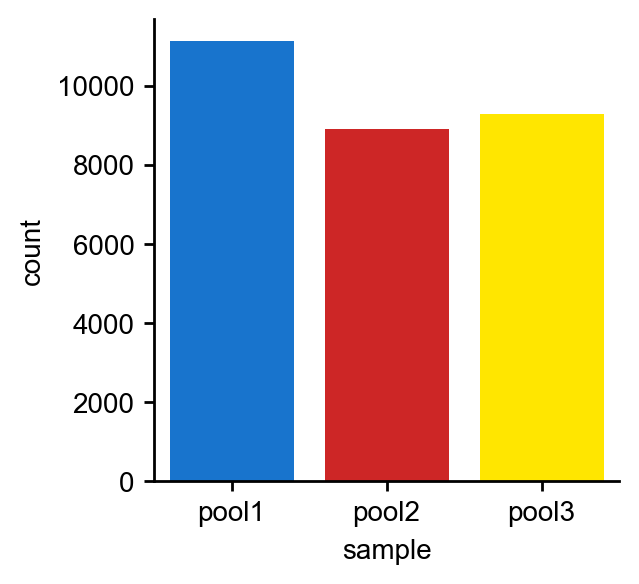

In [9]:
sns.countplot(data = adata.obs, x = "sample",hue = "sample",legend=False,saturation = 1)

UMIs per cell per sample

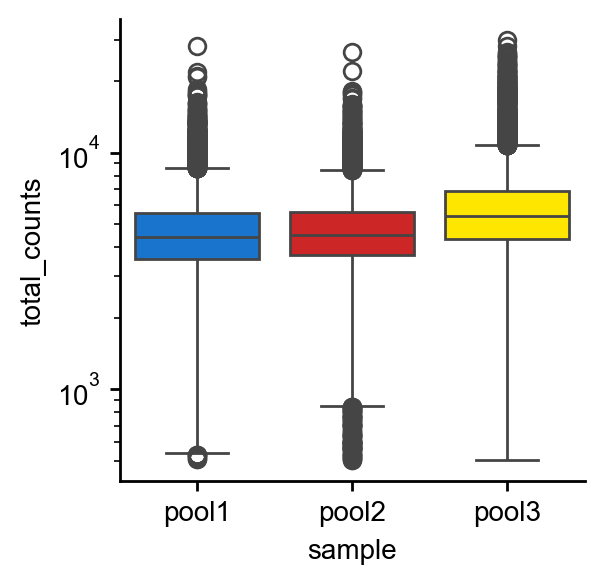

In [10]:
sns.boxplot(data = adata.obs, x = "sample", y = "total_counts",hue = "sample",legend=False,saturation = 1)
plt.yscale("log")

GEX UMIs vs TS UMIs per sample

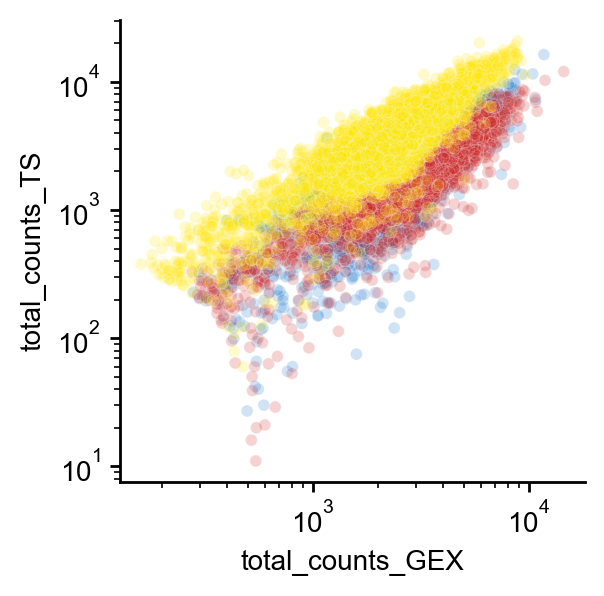

In [11]:
sns.scatterplot(data = adata.obs, x = "total_counts_GEX", y = "total_counts_TS",hue = "sample",legend=False,alpha = 0.2,size = .1)
plt.xscale("log")
plt.yscale("log")

## Low quality cells

In [12]:
adata.obs["type"] = "normal"
adata.obs["pct_counts_MT"] = adata.obs["total_counts_MT"]/adata.obs["total_counts_GEX"]*100

Cells with high mitochondrial content

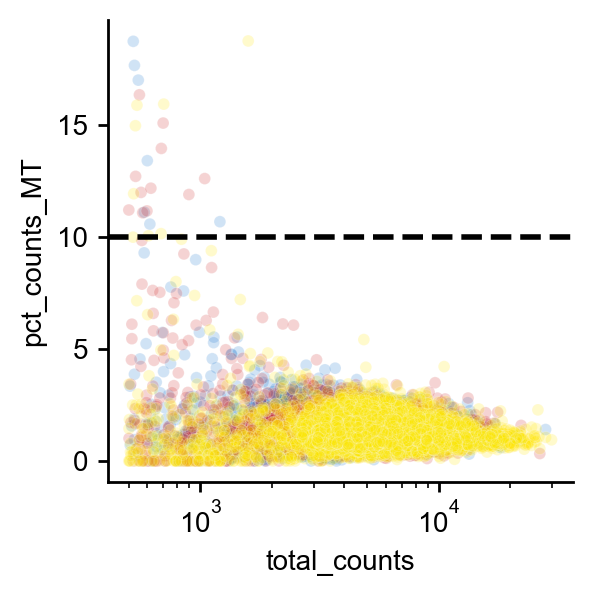

In [13]:
max_mt_pct = 10
adata.obs.loc[adata.obs["pct_counts_MT"] > max_mt_pct, "type"] = "high_mito"
sns.scatterplot(data = adata.obs, x = "total_counts", y = "pct_counts_MT",hue = "sample",legend=False,alpha = 0.2,size = .1)
plt.xscale("log")
plt.axhline(y=max_mt_pct, color="black", linestyle="--")

Cells with too few UMIs

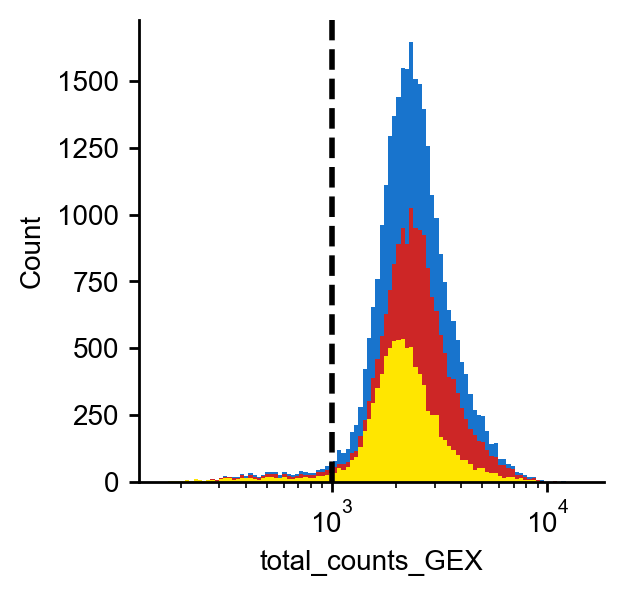

In [14]:
min_gex = 1000
adata.obs.loc[adata.obs["total_counts_GEX"] < min_gex, "type"] = "low_umi"
sns.histplot(data = adata.obs, x = "total_counts_GEX", hue = "sample", bins = 100, log_scale = True,
              legend=False, multiple="stack",linewidth=0,alpha = 1)
plt.axvline(x=min_gex, color="black", linestyle="--")

Cell types

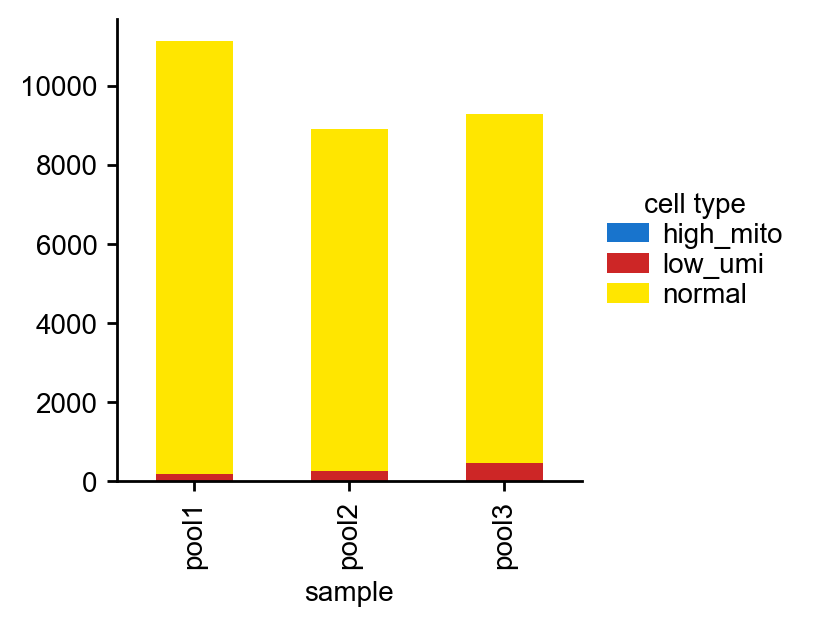

In [15]:
adata.obs.groupby(['sample', 'type'],observed=False).size().unstack(fill_value=0).plot(kind='bar', stacked=True)
plt.legend(loc='center left', title='cell type', bbox_to_anchor=(1, 0.5))

## Filter target site reads

In [16]:
normal_cells = adata.obs.query("type == 'normal'").index
filtered_alleles = alleles.query("cellBC.isin(@normal_cells) & UMI > 1").copy()
filtered_alleles["keep"] = True

Set minimum number of reads per UMI

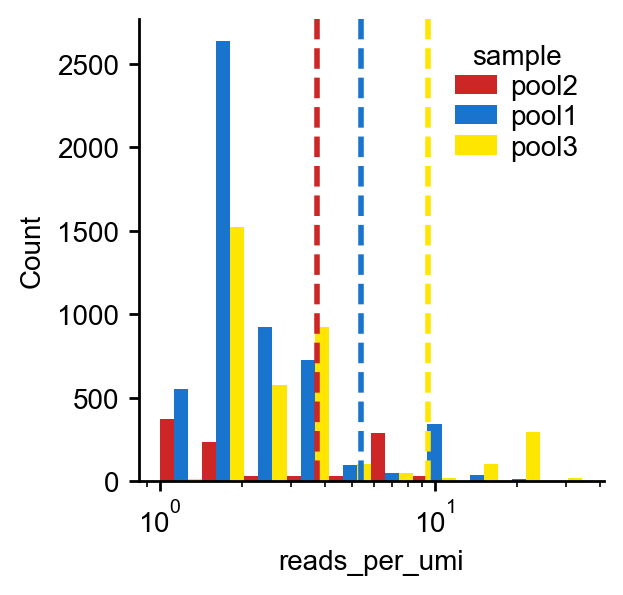

In [17]:
sample_colors = {sample:color for sample, color in zip(sorted(samples.values()),colors[1:])}
filtered_alleles["reads_per_umi"] = filtered_alleles["readCount"]/filtered_alleles["UMI"]
sns.histplot(data = filtered_alleles.sample(10000), x = "reads_per_umi", bins = 10,alpha = 1, 
             log_scale = True, hue = "sample", multiple="dodge",linewidth=0,palette=sample_colors)
for sample, sample_alleles in filtered_alleles.groupby("sample"):
    cutoff = sigma_threshold(sample_alleles["reads_per_umi"],log = True)
    filtered_alleles.loc[(filtered_alleles["sample"] == sample) & (filtered_alleles["reads_per_umi"] < cutoff),"keep"] = False
    plt.axvline(x=cutoff, linestyle="--",color = sample_colors[sample])

Set minimum number of UMIs per target site for each sample

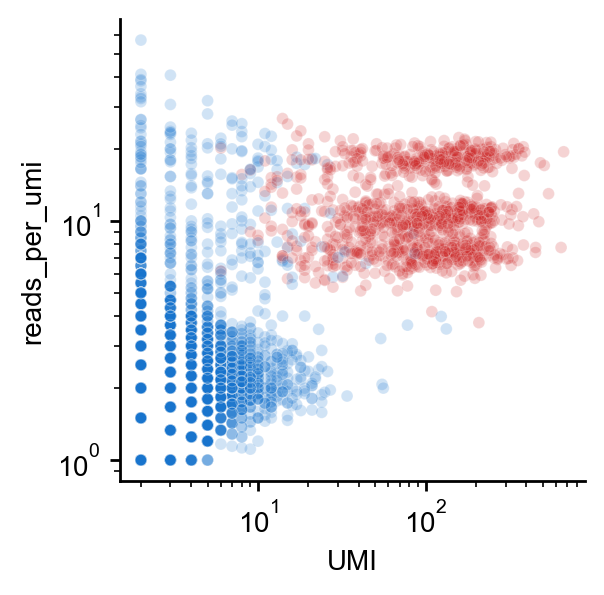

In [18]:
for sample, sample_alleles in filtered_alleles.query("keep").copy().groupby("sample"):
    for integration, int_alleles in sample_alleles.groupby("intID"):
        if len(int_alleles) < 100:
            threshold = np.inf
        else:
            threshold = sigma_threshold(int_alleles["UMI"],log = True)
        filtered_alleles.loc[(filtered_alleles["sample"] == sample) & 
                             (filtered_alleles["intID"] == integration) & 
                             (filtered_alleles["UMI"] <= threshold), "keep"] = False
sns.scatterplot(data = filtered_alleles.sample(10000), x = "UMI", y = "reads_per_umi",
                hue = "keep",size = .1,alpha = .2,legend=False)
plt.yscale("log")
plt.xscale("log")

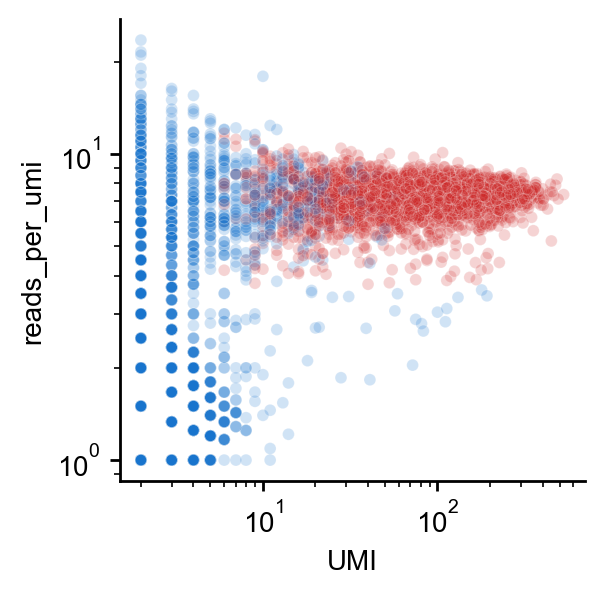

In [19]:
sns.scatterplot(data = filtered_alleles.query("sample == 'pool2'").sample(10000), x = "UMI", y = "reads_per_umi",
                hue = "keep",size = .1,alpha = .2,legend=False)
plt.yscale("log")
plt.xscale("log")

In [20]:
filtered_alleles = filtered_alleles.query("keep").drop(columns="keep").copy()

## Identify clones

In [21]:
normal_cells = adata.obs.query("type == 'normal'").index
filtered_alleles = filtered_alleles.query("cellBC.isin(@normal_cells)").copy()

/home/wcolgan/miniconda3/envs/py10-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


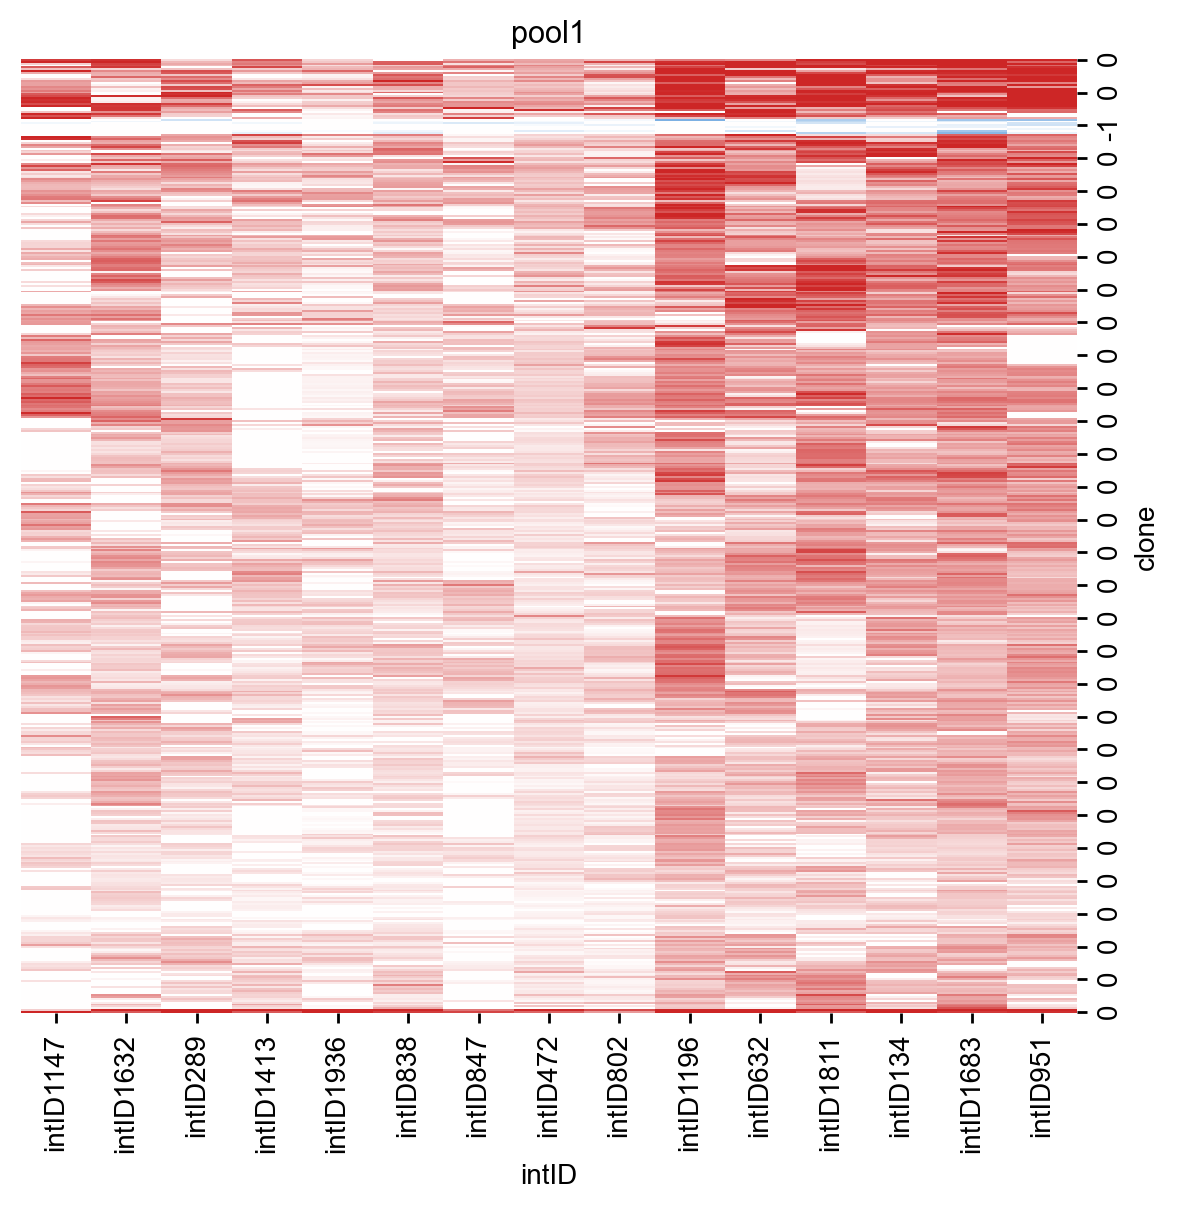

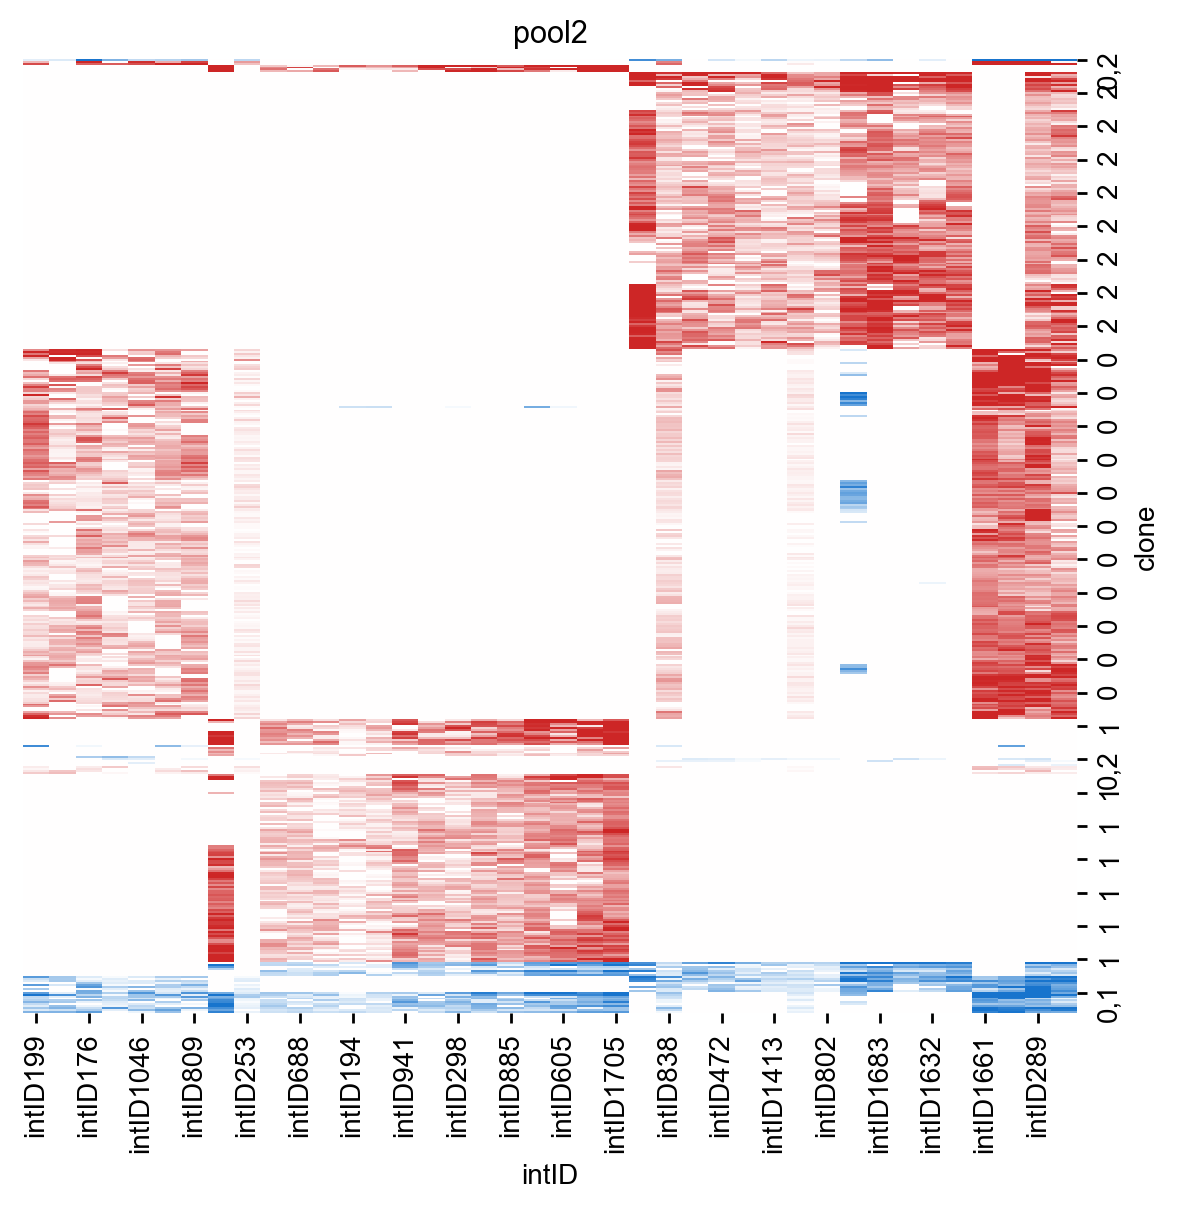

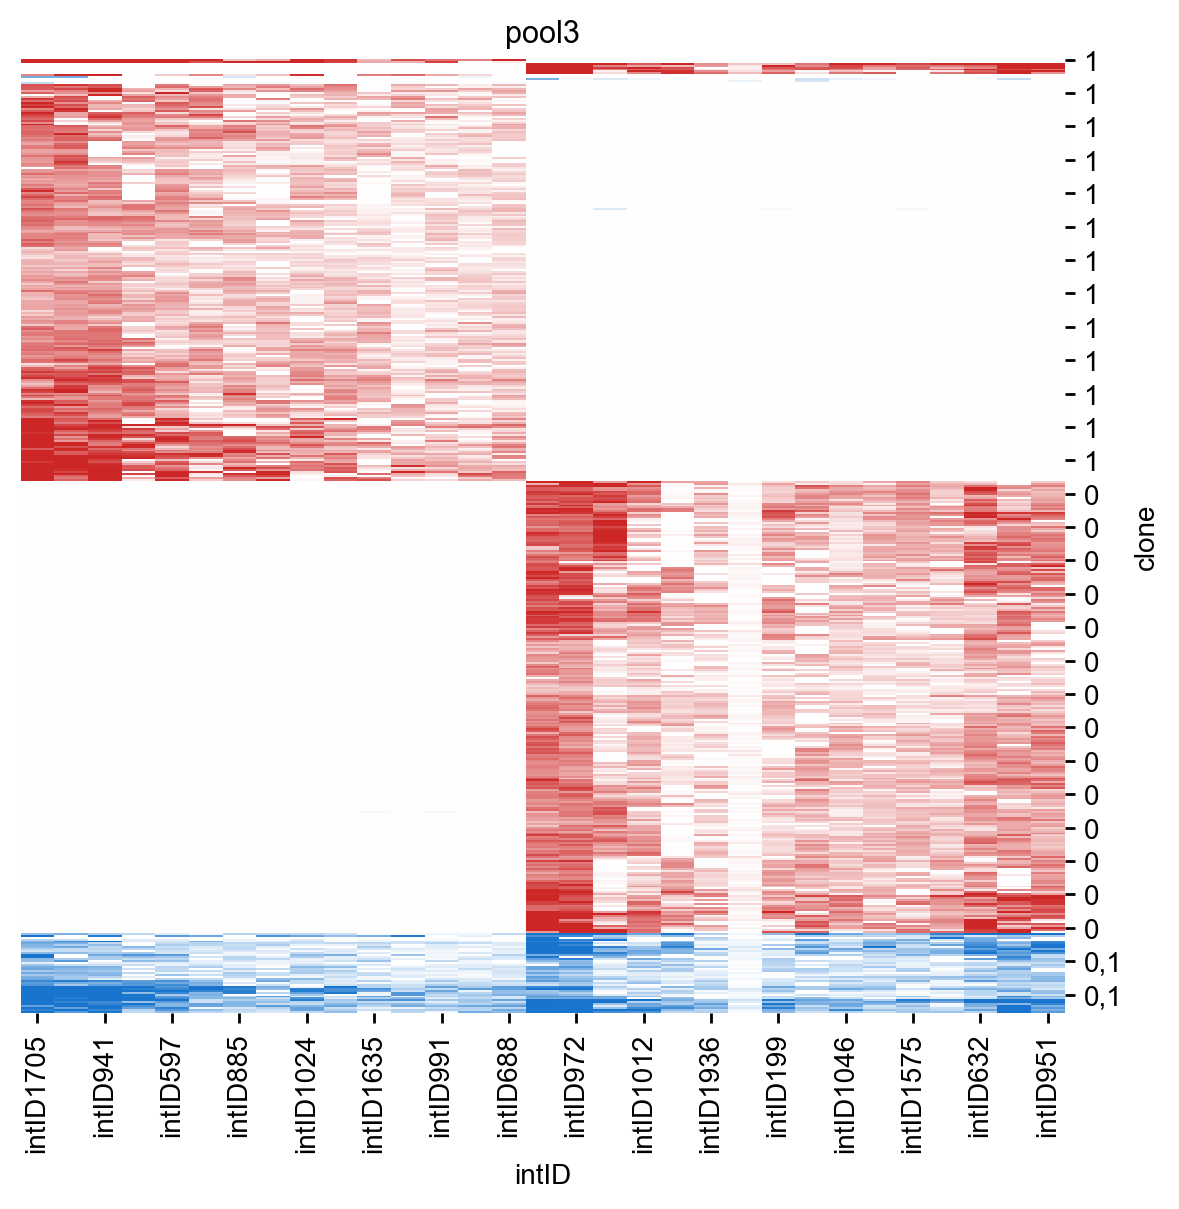

In [22]:
sample_n_clones =  {"pool1":1,"pool2":3,"pool3":2}
min_frac = .5
min_jaccard = .5
whitelist_alleles = []
cell_to_clone = []
for sample, n_clones in sample_n_clones.items():
    model = NMF(n_components=n_clones)
    sample_alleles, sample_clones = call_clones(filtered_alleles.query("sample == @sample"),
                                                model,plot_title = sample,min_frac=min_frac,min_jaccard=min_jaccard)
    whitelist_alleles.append(sample_alleles)
    cell_to_clone.append(sample_clones.assign(sample = sample))
whitelist_alleles = pd.concat(whitelist_alleles)
cell_to_clone = pd.concat(cell_to_clone)

Rename clones by size

In [23]:
clone_counts = cell_to_clone.query("whitelist").groupby(["sample","clone"]).size().reset_index(name = "n").sort_values("n",ascending = False)
clone_counts["unique_clone"] = (clone_counts.reset_index().index + 1).astype(str)
clone_counts

,sample,clone,n,unique_clone
0,pool1,0,10707,1
4,pool3,0,4203,2
5,pool3,1,3810,3
1,pool2,0,3258,4
2,pool2,1,2410,5
3,pool2,2,2337,6


Add clone to cells and alleles

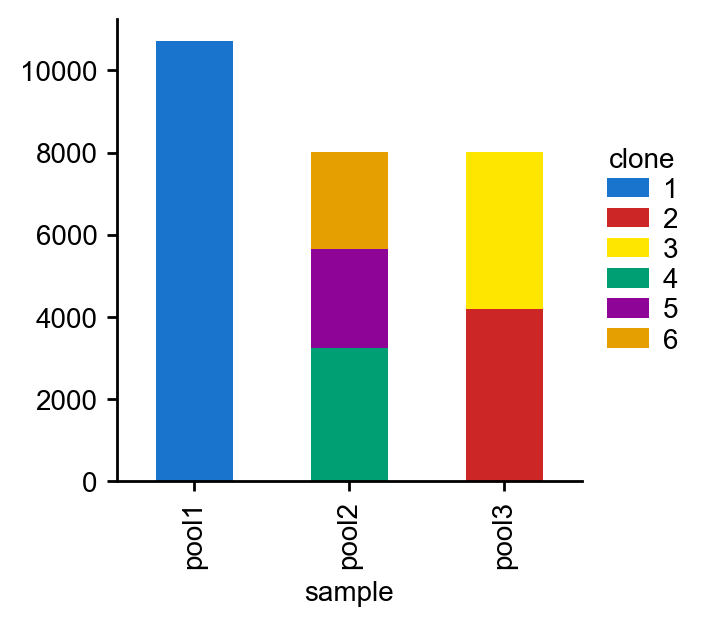

In [24]:
cell_to_clone = cell_to_clone.merge(clone_counts[["sample","clone","unique_clone"]], on = ["sample","clone"], how = "left")
filtered_alleles = whitelist_alleles.copy()
filtered_alleles["clone"] = filtered_alleles["cellBC"].map(cell_to_clone.set_index("cellBC")["unique_clone"])
adata.obs["clone"] = adata.obs["cellBC"].map(cell_to_clone.set_index("cellBC")["unique_clone"])
adata.obs.groupby(['sample', 'clone'],observed=False).size().unstack(fill_value=0).plot(kind='bar', stacked=True)
plt.legend(loc='center left', title='clone', bbox_to_anchor=(1, 0.5))

Mark doublets and unassigned cells

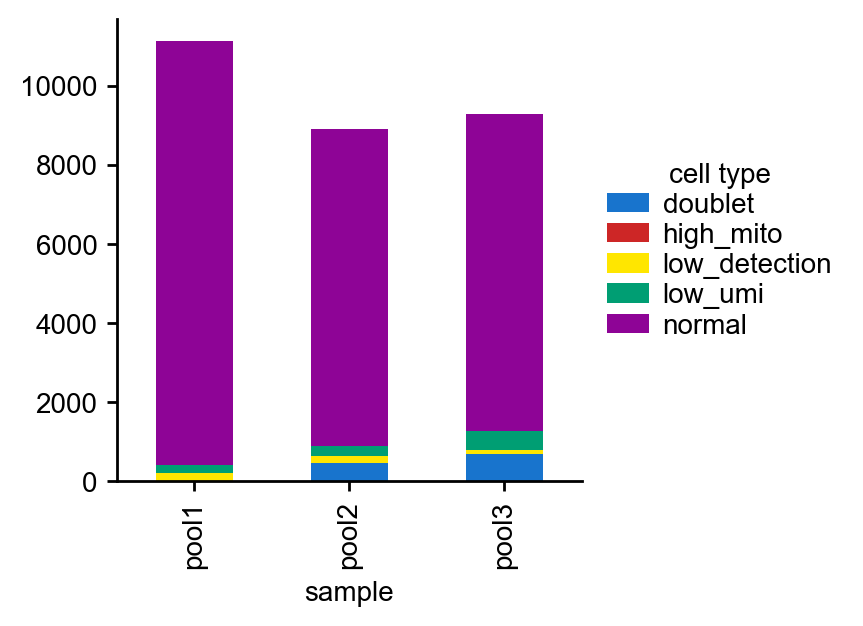

In [25]:
doublets = cell_to_clone.query("clone.str.contains(',')")["cellBC"]
adata.obs.loc[doublets, "type"] = "doublet"
adata.obs.loc[(adata.obs.type == "normal") & adata.obs.clone.isna(), "type"] = "low_detection"
adata.obs.groupby(['sample', 'type'],observed=False).size().unstack(fill_value=0).plot(kind='bar', stacked=True)
plt.legend(loc='center left', title='cell type', bbox_to_anchor=(1, 0.5))

## Filter alleles

In [26]:
normal_cells = adata.obs.query("type == 'normal'").index
filtered_alleles = filtered_alleles.query("cellBC.isin(@normal_cells)").copy()

Remove alleles with < 20% of UMIs in a cell

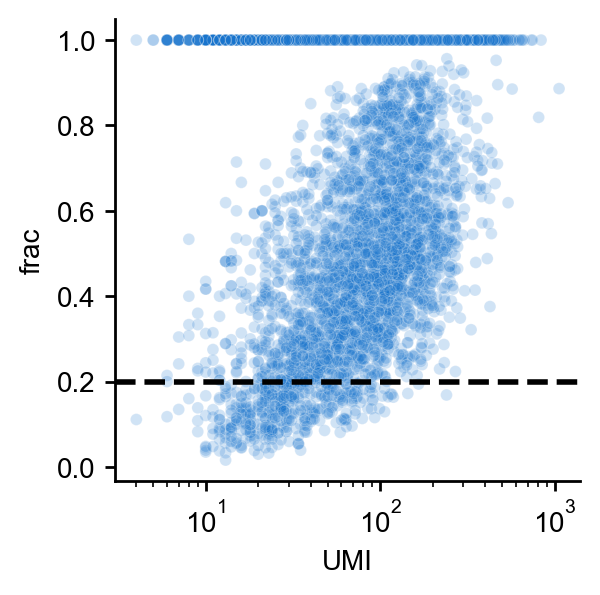

In [27]:
min_umi_frac = .2
filtered_alleles["frac"] = filtered_alleles["UMI"] / filtered_alleles.groupby(["cellBC", "intID"])["UMI"].transform("sum")
sns.scatterplot(filtered_alleles.sample(10000), x = "UMI",y = "frac",alpha = .2,size = .1,legend=False)
plt.xscale("log")
plt.axhline(y=min_umi_frac, color="black", linestyle="--")
filtered_alleles = filtered_alleles.query("frac > @min_umi_frac").copy()

Select allele with the most edits as long as the alleles differ by at most one edit

In [28]:
filtered_alleles["n_alleles"] = filtered_alleles.groupby(['intID', 'cellBC'])["intID"].transform("count")
selected_alleles = filtered_alleles[filtered_alleles.n_alleles == 2].groupby(['intID', 'cellBC']).apply(select_allele).reset_index(drop = True)
filtered_alleles = pd.concat([filtered_alleles[filtered_alleles.n_alleles != 2],selected_alleles])

/tmp/ipykernel_2910339/3876977017.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  selected_alleles = filtered_alleles[filtered_alleles.n_alleles == 2].groupby(['intID', 'cellBC']).apply(select_allele).reset_index(drop = True)


Remove integrations with conflicts in >25% of UMIs

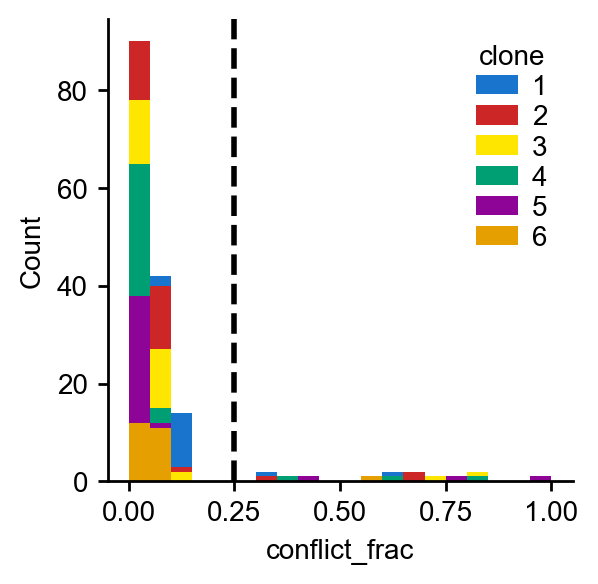

In [29]:
max_int_conflict = .25
int_conflicts = filtered_alleles[filtered_alleles.n_alleles > 1].groupby(["clone","intID"])["UMI"].sum() / filtered_alleles.groupby(["clone","intID"])["UMI"].sum()
int_conflicts = int_conflicts.reset_index().fillna(0).rename(columns = {"UMI":"conflict_frac"})
filtered_alleles = filtered_alleles.merge(int_conflicts, on = ["clone","intID"]).query(
    "conflict_frac < @max_int_conflict ").copy().drop(columns = "conflict_frac")
sns.histplot(int_conflicts, x = "conflict_frac",bins = 20,hue = "clone",multiple="stack",linewidth=0,alpha = 1)
plt.axvline(x=max_int_conflict, color="black", linestyle="--")

Mark cells with conflicts in >25% of integration UMIs as doublets

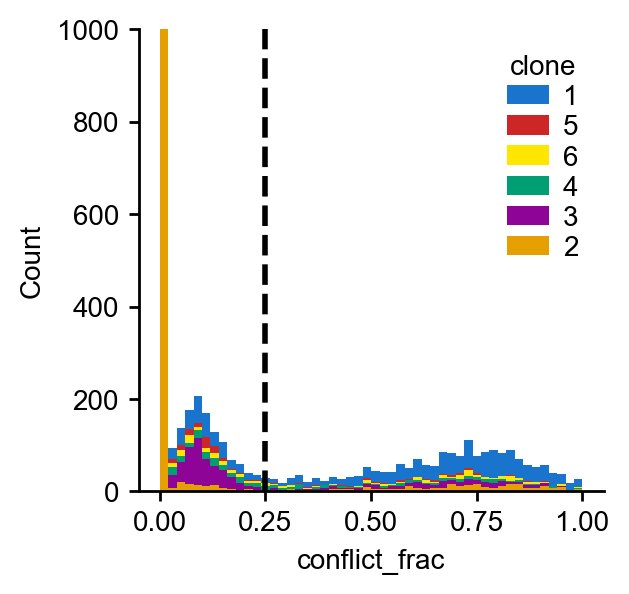

In [30]:
max_cell_conflict = .25
cell_conflicts = filtered_alleles[filtered_alleles.n_alleles > 1].groupby(["cellBC","clone"])["UMI"].sum() / filtered_alleles.groupby(["cellBC","clone"])["UMI"].sum()
cell_conflicts = cell_conflicts.reset_index().fillna(0).rename(columns = {"UMI":"conflict_frac"})
sns.histplot(cell_conflicts, x = "conflict_frac",bins = 50,hue = "clone",multiple = "stack",linewidth=0,alpha = 1)
plt.ylim(0,1000)
plt.axvline(x=max_cell_conflict, color="black", linestyle="--")
doublets = cell_conflicts.query("conflict_frac > @max_cell_conflict")["cellBC"]

Resolve remaining conflict by selecting allele with most UMIs

In [31]:
filtered_alleles = filtered_alleles[~filtered_alleles.cellBC.isin(doublets)].copy()
filtered_alleles = filtered_alleles.sort_values("frac",ascending = False).groupby(
    ["intID","cellBC"]).first().reset_index().drop(columns = ["frac","n_alleles"])

Mark doublets

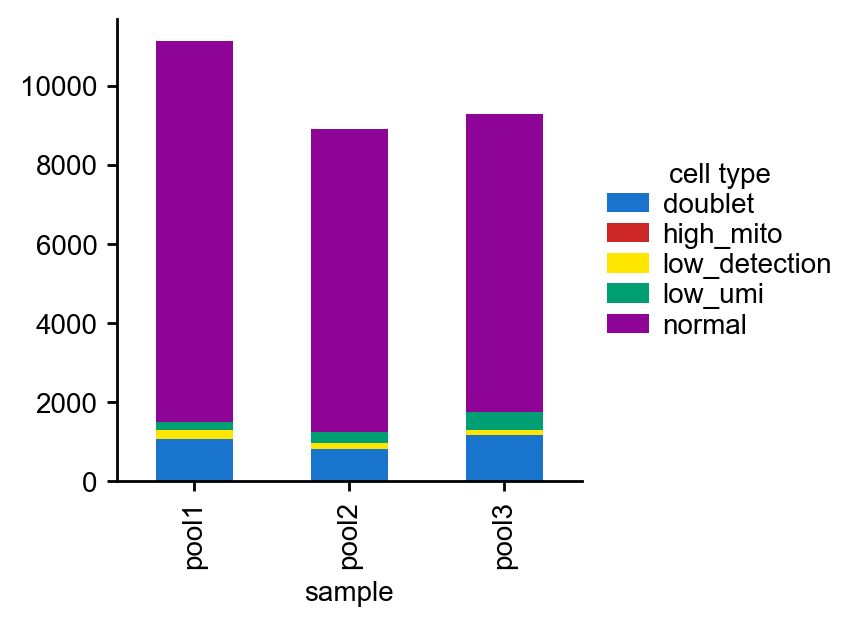

In [32]:
adata.obs.loc[doublets, "type"] = "doublet"
adata.obs.groupby(['sample', 'type'],observed=False).size().unstack(fill_value=0).plot(kind='bar', stacked=True)
plt.legend(loc='center left', title='cell type', bbox_to_anchor=(1, 0.5))

## Allele statistics

Detection rate

<Axes: xlabel='clone', ylabel='detection_rate'>

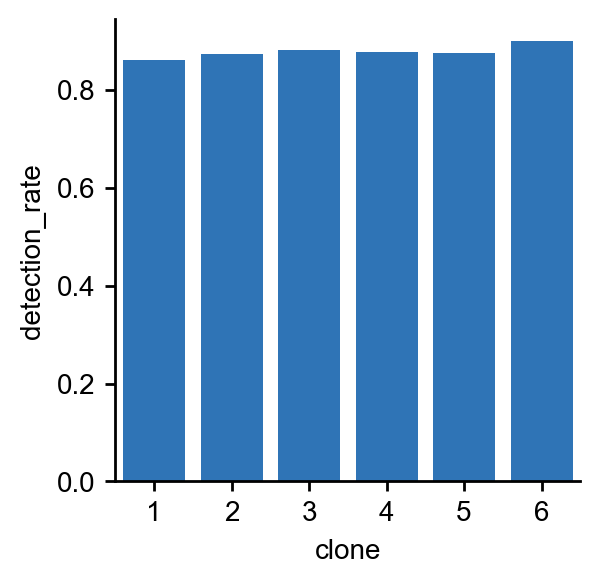

In [33]:
int_detection = (filtered_alleles.query("whitelist").groupby(["intID","clone","sample"]).size() / 
                 filtered_alleles.query("whitelist").groupby(["clone","sample"])["cellBC"].nunique())
int_detection = int_detection.reset_index(name = "detection_rate")
sns.barplot(data = int_detection.groupby(["clone"]).agg({"detection_rate":"mean"}).reset_index(),y = "detection_rate",x = "clone")

Detection rate per integration

<Axes: xlabel='clone', ylabel='intID'>

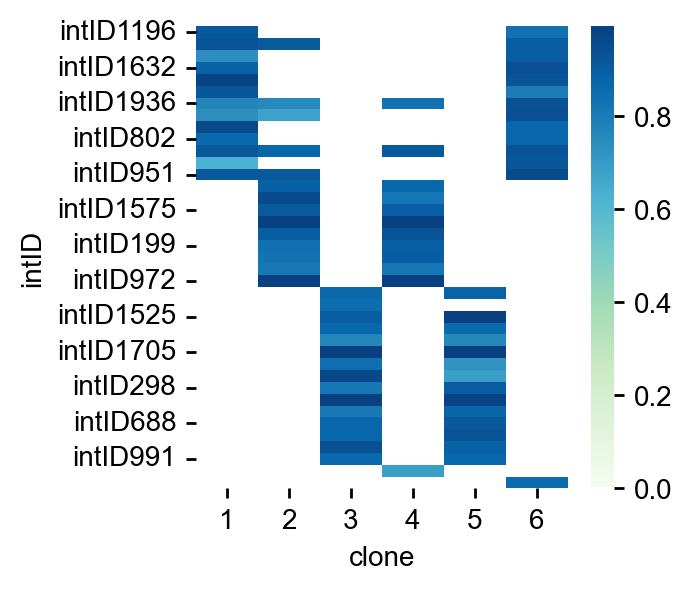

In [34]:
int_order = int_detection.intID.drop_duplicates()
int_detection_wide = pd.pivot_table(int_detection,columns=["clone"], index=["intID"], values="detection_rate")
sns.heatmap(int_detection_wide.loc[int_order,:],cmap = sequential_cmap,vmin = 0)

Edit fraction

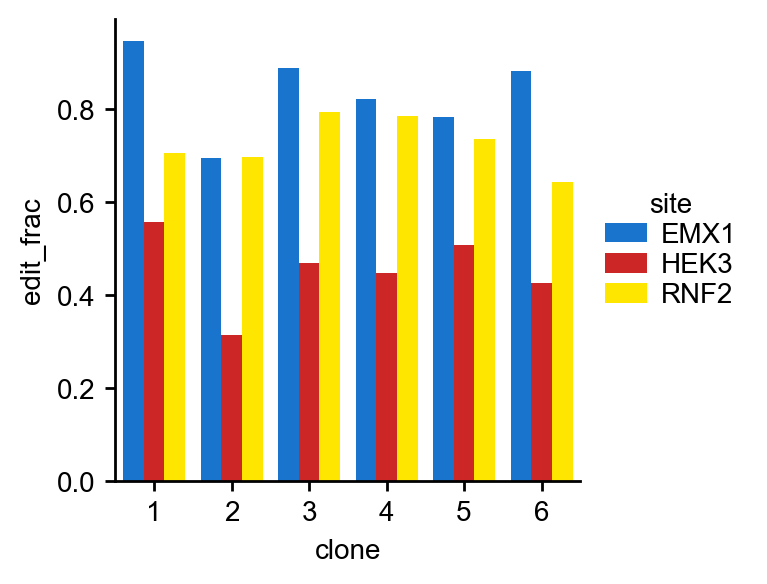

In [35]:
edit_counts = filtered_alleles.query("whitelist")[site_names + ['UMI',"cellBC","intID","clone","sample"]].melt(
    id_vars = ["cellBC","UMI","intID","clone","sample"],value_name="edit", var_name="site")
edit_frac = edit_counts.query("edit != 'None'").groupby(["clone","sample","intID","site"]).size()/ \
    edit_counts.groupby(["clone","sample","intID","site"]).size()
edit_frac = edit_frac.reset_index(name = "edit_frac").groupby(["clone","site"]).agg({"edit_frac":"mean"}).reset_index()
sns.barplot(data = edit_frac,y = "edit_frac",x = "clone",hue = "site",saturation=1)
plt.legend(loc='center left', title='site', bbox_to_anchor=(1, 0.5))

Edit frequency

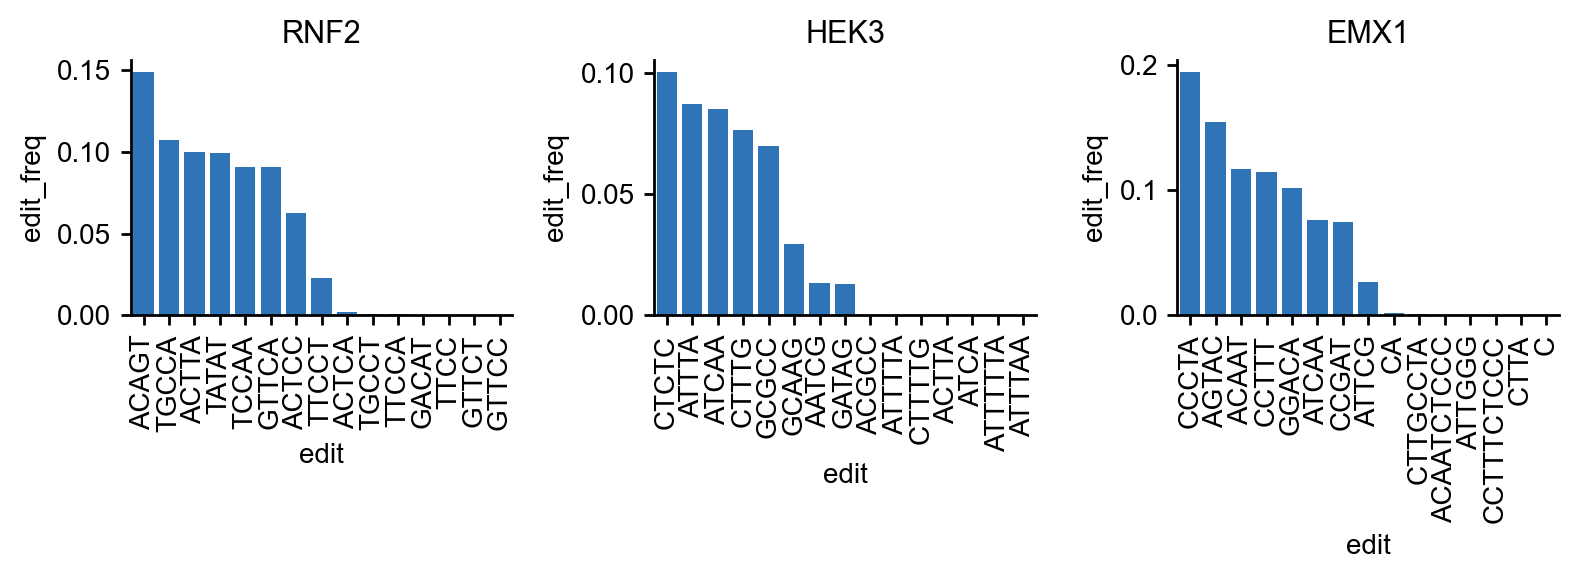

In [36]:
edit_frequency =  edit_counts.groupby(["site","edit"]).size() / edit_counts.groupby(["site"]).size()
edit_frequency = edit_frequency.reset_index(name = "edit_freq")
fig, axes = plt.subplots(1, 3, figsize=(8, 3))
for i, site in enumerate(site_names):
    sns.barplot(
        data=edit_frequency.query(f"site == '{site}' & edit != 'None'").sort_values("edit_freq", ascending=False).head(15),
        x="edit",y="edit_freq", ax=axes[i])
    axes[i].set_title(site)
    plt.setp(axes[i].get_xticklabels(), rotation=90)
plt.tight_layout()

## Barcode groups

setup

In [37]:
from src.barcode_utils import cluster_barcodes

load data

In [38]:
barcode_names = {"PuroBC":"puro","BlastBC":"blast"}
barcodes = []
for sample, name in samples.items():
    for barcode, bc_name in barcode_names.items():
        sample_barcodes = pd.read_csv(data_path / sample / f"{sample}_{barcode}_counts.csv")
        sample_barcodes.rename(columns={f"{barcode}":"intBC"},inplace=True)
        sample_barcodes["sample"] = name
        sample_barcodes["barcode"] = bc_name
        sample_barcodes["cellBC"] = (name + "-" + sample_barcodes["cellBC"])
        barcodes.append(sample_barcodes)
barcodes = pd.concat(barcodes, join='outer')
normal_cells = adata.obs.query("type == 'normal'").index
filtered_barcodes = barcodes.query("cellBC.isin(@normal_cells)").copy()
filtered_barcodes = filtered_barcodes.merge(adata.obs[["cellBC","clone"]], on = "cellBC")

Set minumum number of umis per barcode

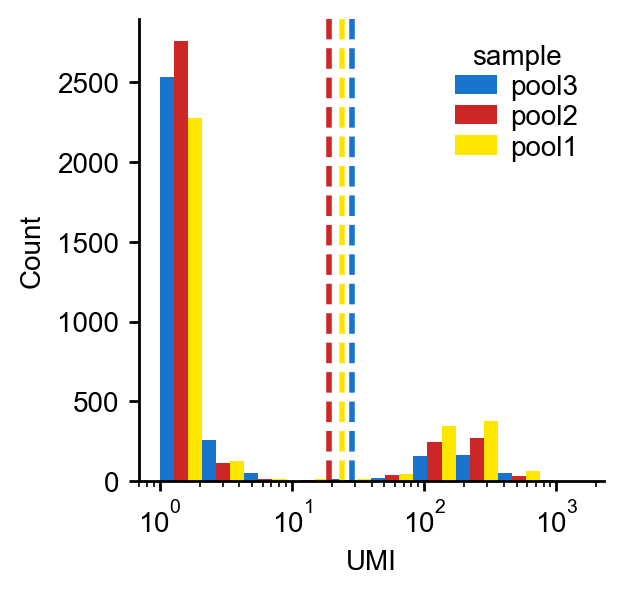

In [39]:
filtered_barcodes["keep"] = True
sns.histplot(data = filtered_barcodes.sample(10000), x = "UMI",bins = 10,alpha = 1,log_scale= True,
             hue = "sample",multiple="dodge",linewidth=0)
for sample, sample_barcodes in filtered_barcodes.groupby("sample"):
    threshold = sigma_threshold(sample_barcodes["UMI"],log = True)
    filtered_barcodes.loc[(filtered_barcodes["sample"] == sample) & (filtered_barcodes["UMI"] < threshold),"keep"] = False
    plt.axvline(x=threshold, linestyle="--",color = sample_colors[sample])
filtered_barcodes = filtered_barcodes.query("keep").copy()

Cluster barcodes

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

from src.config import sequential_cmap
from src.tree_utils import get_root, get_leaves

def score_kinship(int_counts,ints):
    return int_counts[ints].sum(axis = 1)/int_counts.sum(axis = 1)

def group_from_seed(int_counts,seed,min_frac = .8,min_kinship = .8,min_count = 10):
    int_pass = int_counts >= min_count
    int_fracs = int_pass.loc[int_pass[seed],:].mean()
    ints = int_fracs[int_fracs >= min_frac].index
    kinship = score_kinship(int_counts,ints)
    cells = kinship[kinship >= min_kinship].index
    return list(ints), list(cells)

def cluster_barcodes(barcodes,min_size = 2,min_count = 10, plot = False,plot_title = None):
    barcode_counts = barcodes.pivot_table(index=['cellBC'], columns='intBC', values='UMI').fillna(0)
    seeds = list((barcode_counts > min_count).sum(axis = 0).sort_values(ascending = False).index)
    unassigned = set(barcode_counts.index)
    cluster = 1
    cell_to_cluster = []
    int_order = []
    while len(unassigned) > 0 and len(seeds) > 0:
        seed = seeds.pop(0)
        ints, cells = group_from_seed(barcode_counts.loc[list(unassigned),:],seed,min_count = min_count)
        if len(cells) >= min_size:
            cell_to_cluster.append(pd.DataFrame({"cellBC":cells,"cluster":cluster}))
            int_order += list(set(ints) - set(int_order))
            cluster += 1
            unassigned = unassigned - set(cells)
    cell_to_cluster = pd.concat(cell_to_cluster)
    cell_to_cluster["cluster"] = cell_to_cluster["cluster"].astype(str)
    if plot:
        fig, axes = plt.subplots(1, 1, figsize=(5, 4))
        sns.heatmap(barcode_counts.loc[cell_to_cluster.cellBC,int_order],cmap = sequential_cmap,vmax = 50,
                    yticklabels=False,xticklabels=False,ax = axes)
        plt.title(plot_title)
    return cell_to_cluster, barcode_counts.loc[:,int_order]

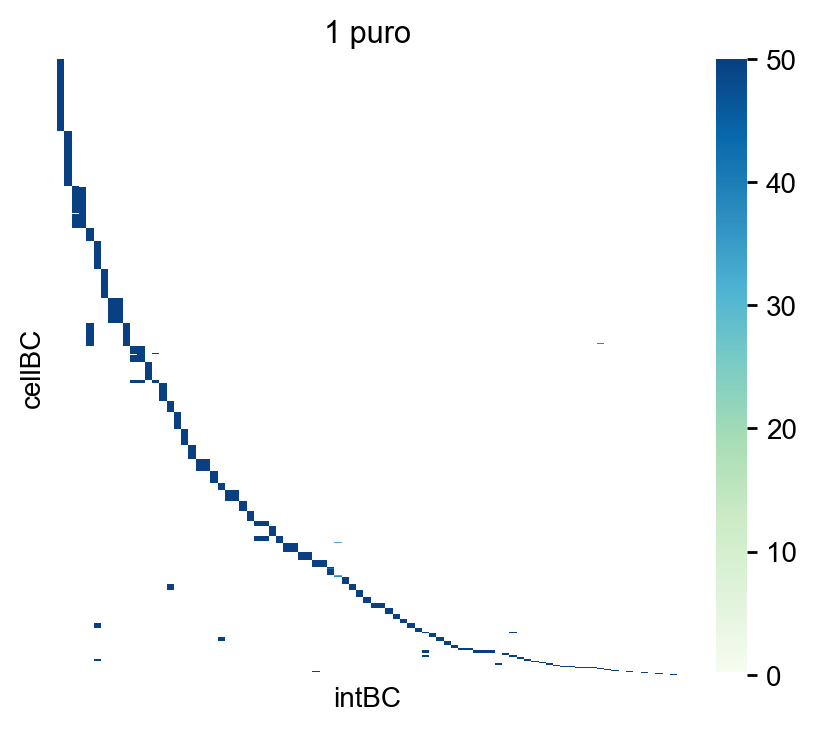

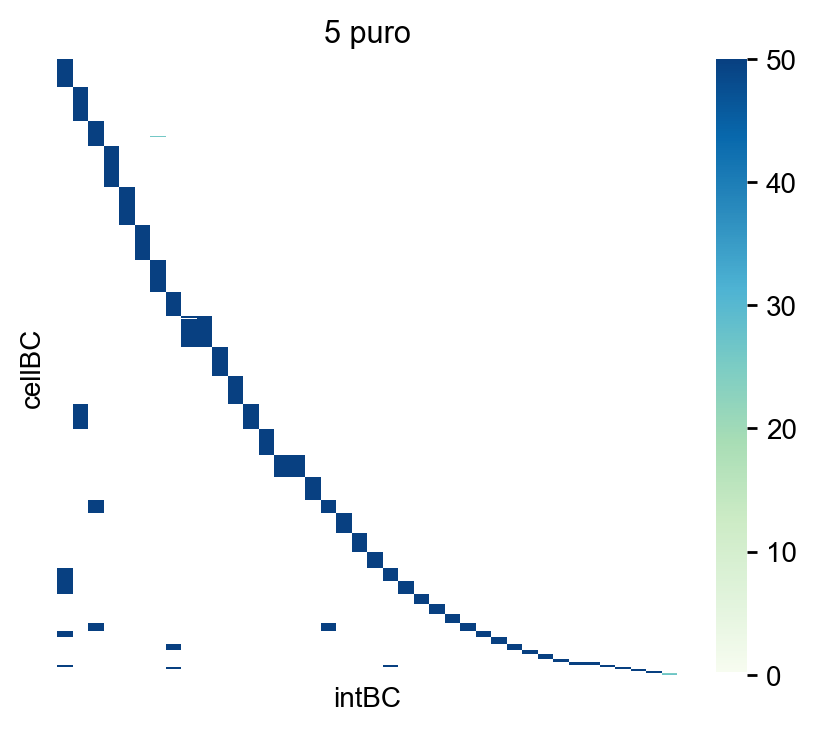

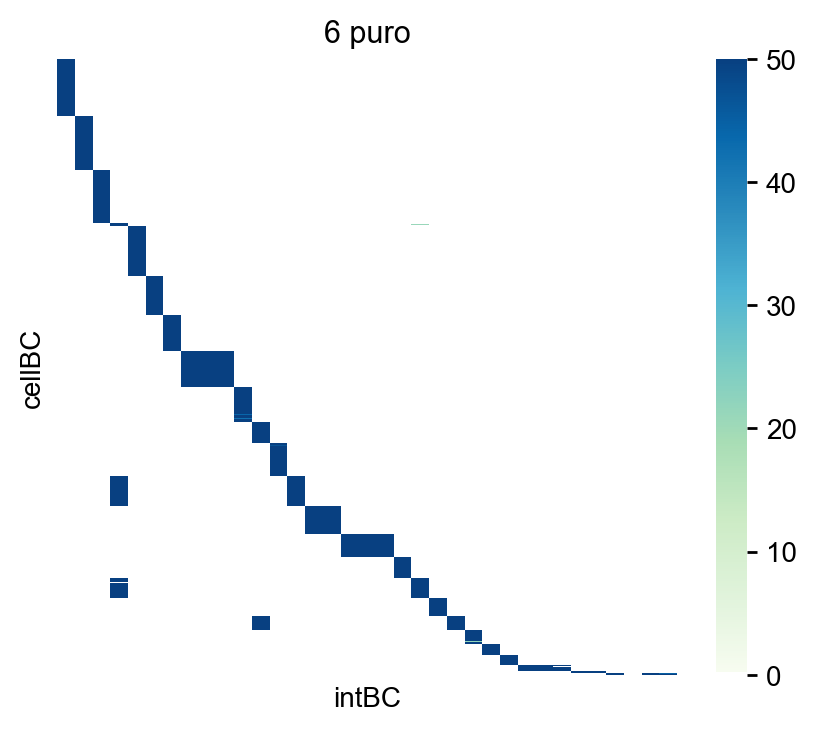

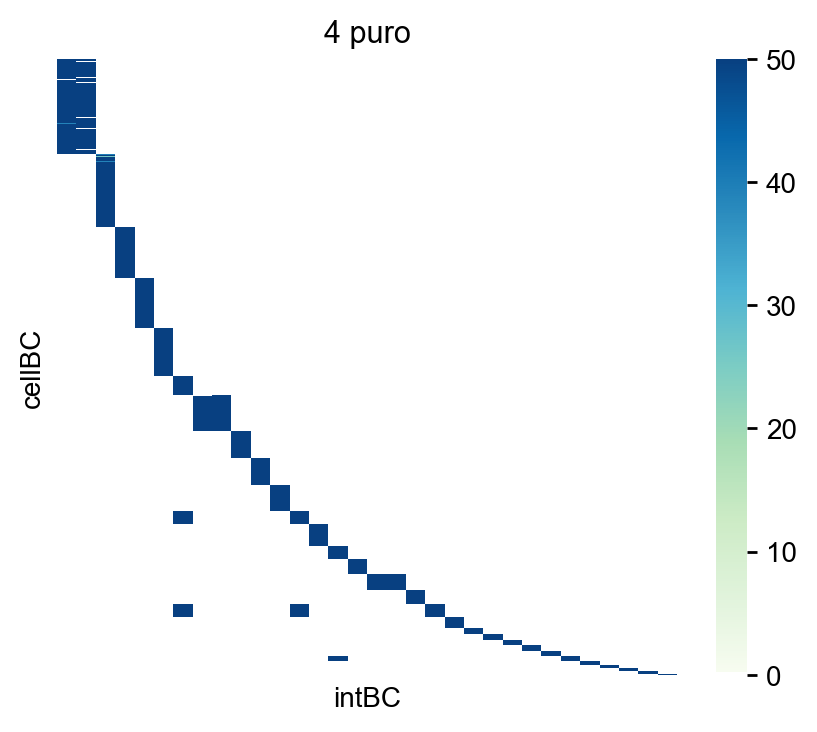

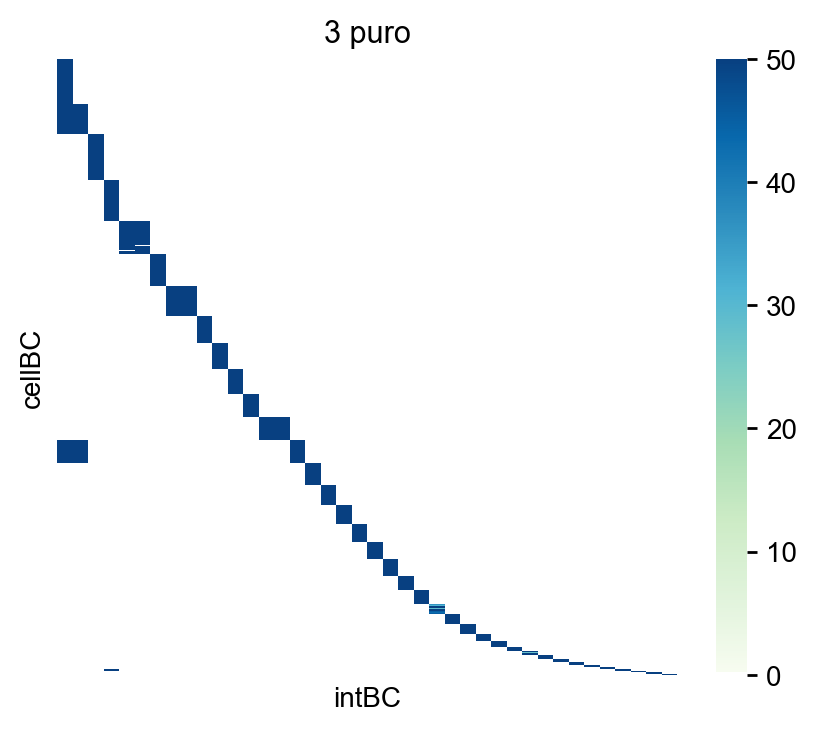

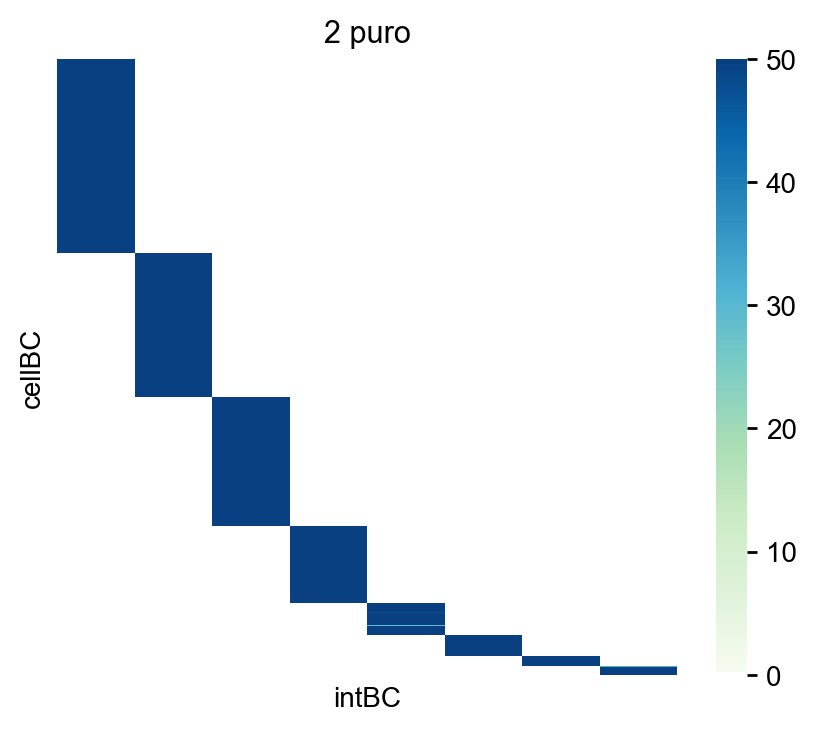

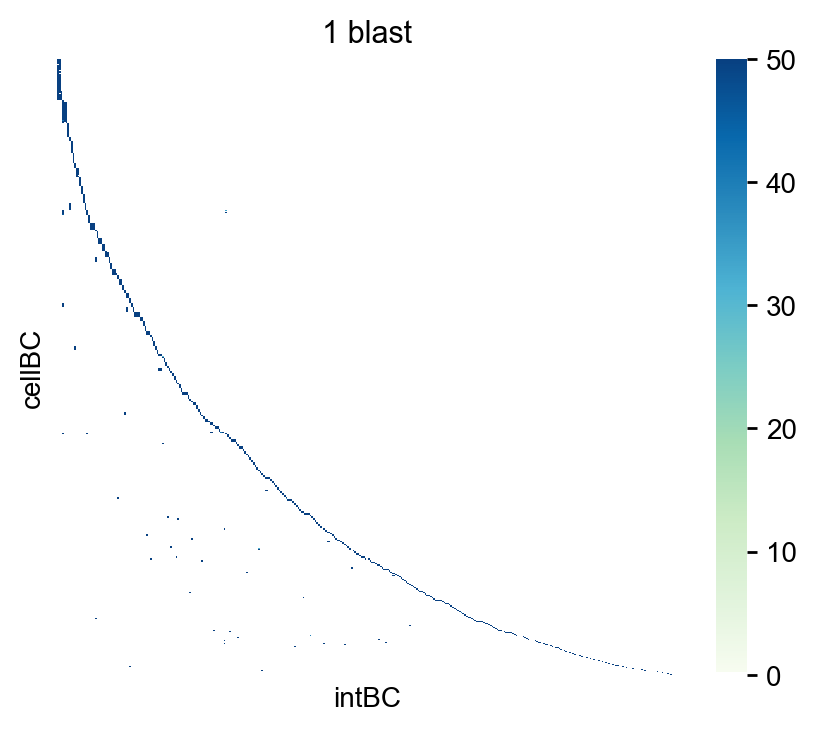

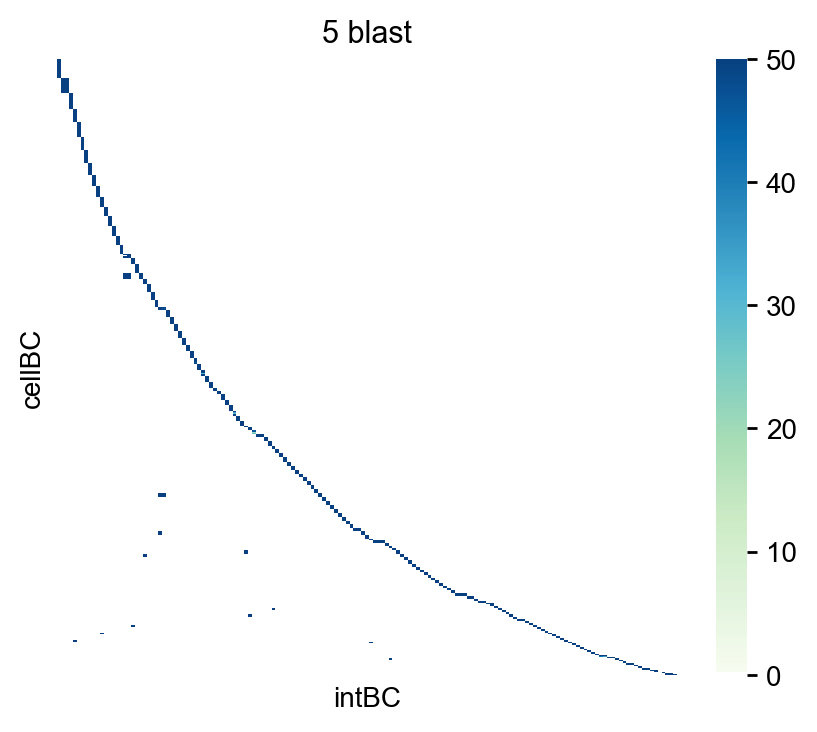

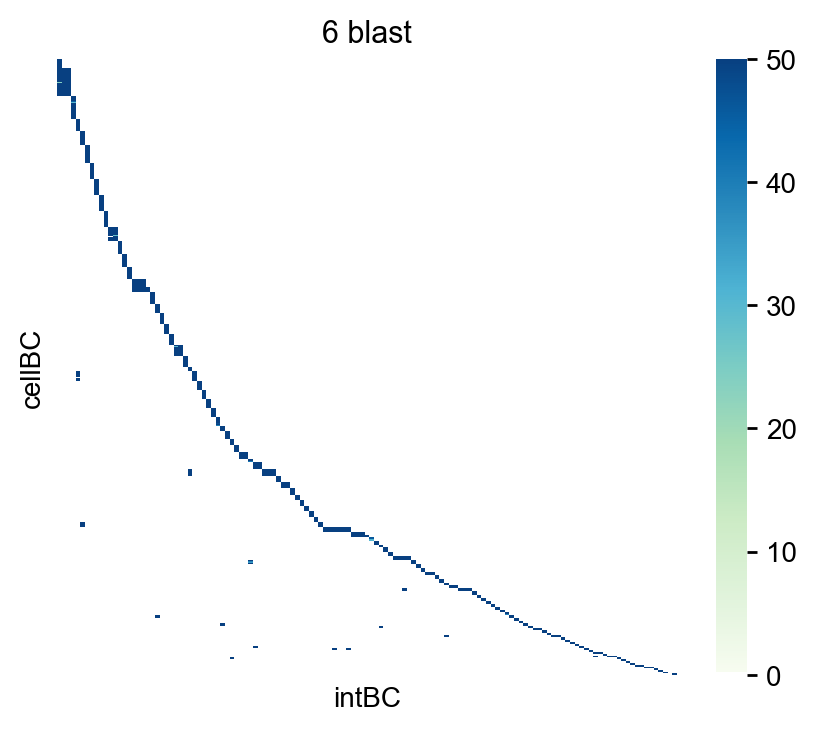

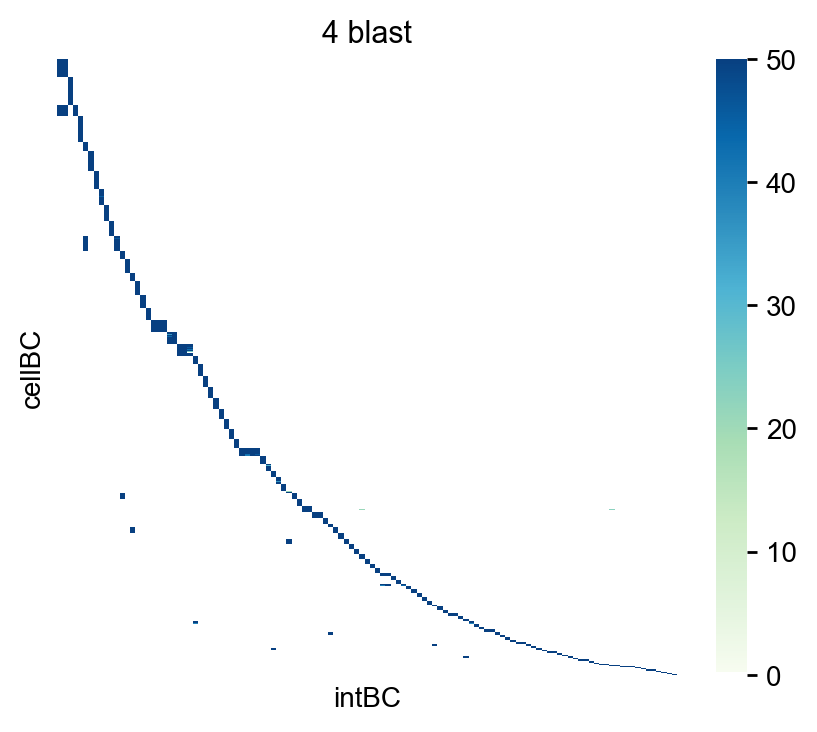

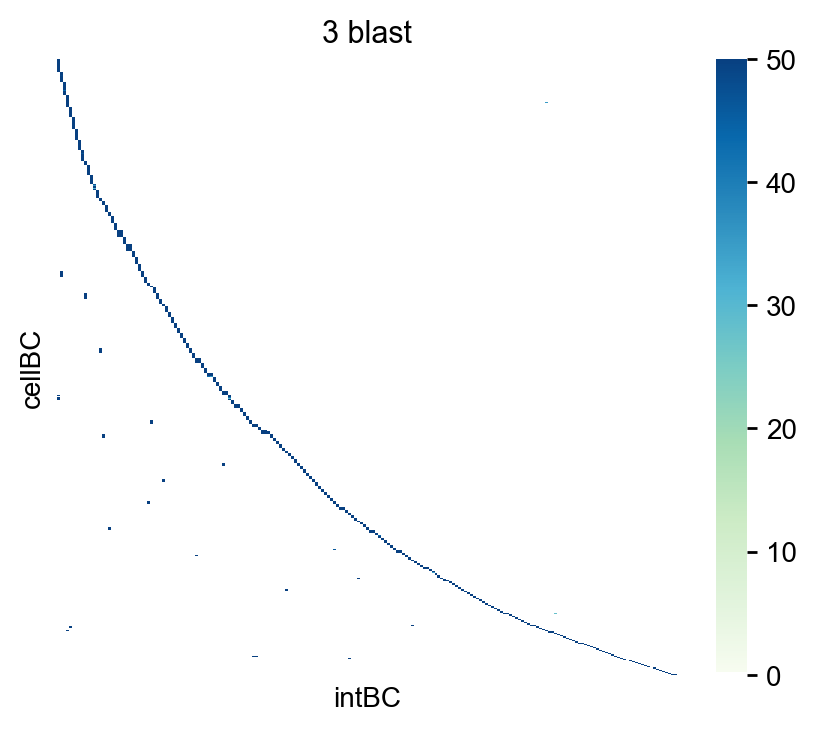

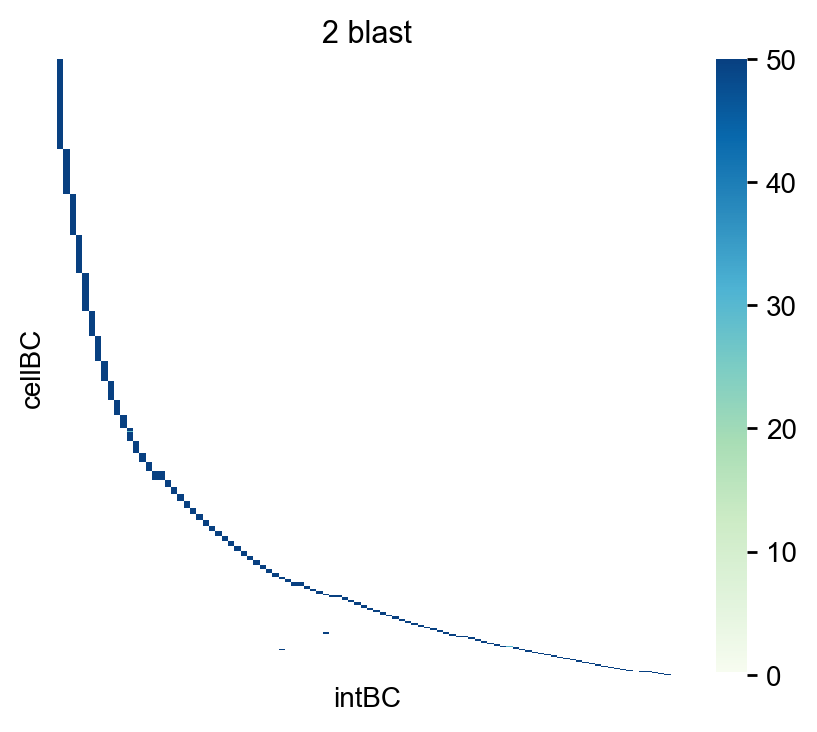

In [87]:
clone_barcode_counts = {"puro":{},"blast":{}}
for barcode in barcode_names.values():
    cell_to_cluster = []
    for clone in adata.obs["clone"].dropna().unique():
        clone_clusters, clone_counts = cluster_barcodes(filtered_barcodes.query("clone == @clone & barcode == @barcode"),
                                                plot = True,plot_title=f"{clone} {barcode}",min_size=5)
        cell_to_cluster.append(clone_clusters)
        clone_barcode_counts[barcode][clone] = clone_counts
    adata.obs[barcode] = adata.obs["cellBC"].map(pd.concat(cell_to_cluster).set_index("cellBC")["cluster"])

In [59]:
test = pd.concat(barcode_counts).fillna(0)

In [60]:
# convert to sparse matrix
import scipy as sp
sparse_test = sp.sparse.csr_matrix(test.values)

In [63]:
test_adata = adata.copy()

In [61]:
sparse_test.data

array([114., 123.,  93., ..., 245., 149., 155.])

In [55]:
np.sum(np.sum(test > 0))

30346

In [56]:
test.shape

(23533, 1074)

In [57]:
23533 * 1074

25274442

In [62]:
sparse_test

<23533x1074 sparse matrix of type '<class 'numpy.float64'>'
	with 30346 stored elements in Compressed Sparse Row format>

## Reconstruct trees

Setup

In [72]:
tdata = td.TreeData(adata[adata.obs["type"] == "normal",adata.var["GEX"]].copy())
tdata.obs = tdata.obs[["cellBC","sample","clone","type","puro","blast"]]
tdata.var = tdata.var[["mean_counts","total_counts"]]

Reconstruct clones

In [73]:
def reconstruct_clone(clone):
    clone_tdata = tdata[tdata.obs["clone"] == clone,:].copy()
    clone_tdata.obsm["characters"] = alleles_to_characters(filtered_alleles.query("whitelist & clone == @clone"))
    reconstruct_tree(clone_tdata, solver = "upgma",collapse_edges=True)
    return clone, clone_tdata

with mp.Pool(processes=8) as pool:
    results = pool.map(reconstruct_clone, tdata.obs["clone"].dropna().unique())

clones = {}
for clone , tdata in results:
    clones[clone] = tdata

/home/wcolgan/miniconda3/envs/py10-env/lib/python3.10/site-packages/cvxpy/problems/problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
/home/wcolgan/miniconda3/envs/py10-env/lib/python3.10/site-packages/cvxpy/problems/problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
/home/wcolgan/miniconda3/envs/py10-env/lib/python3.10/site-packages/cvxpy/problems/problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
/home/wcolgan/miniconda3/envs/py10-env/lib/python3.10/site-packages/cvxpy/problems/problem.py:158: UserWarning: Objective contains too many subexpressions. C

Plot clones

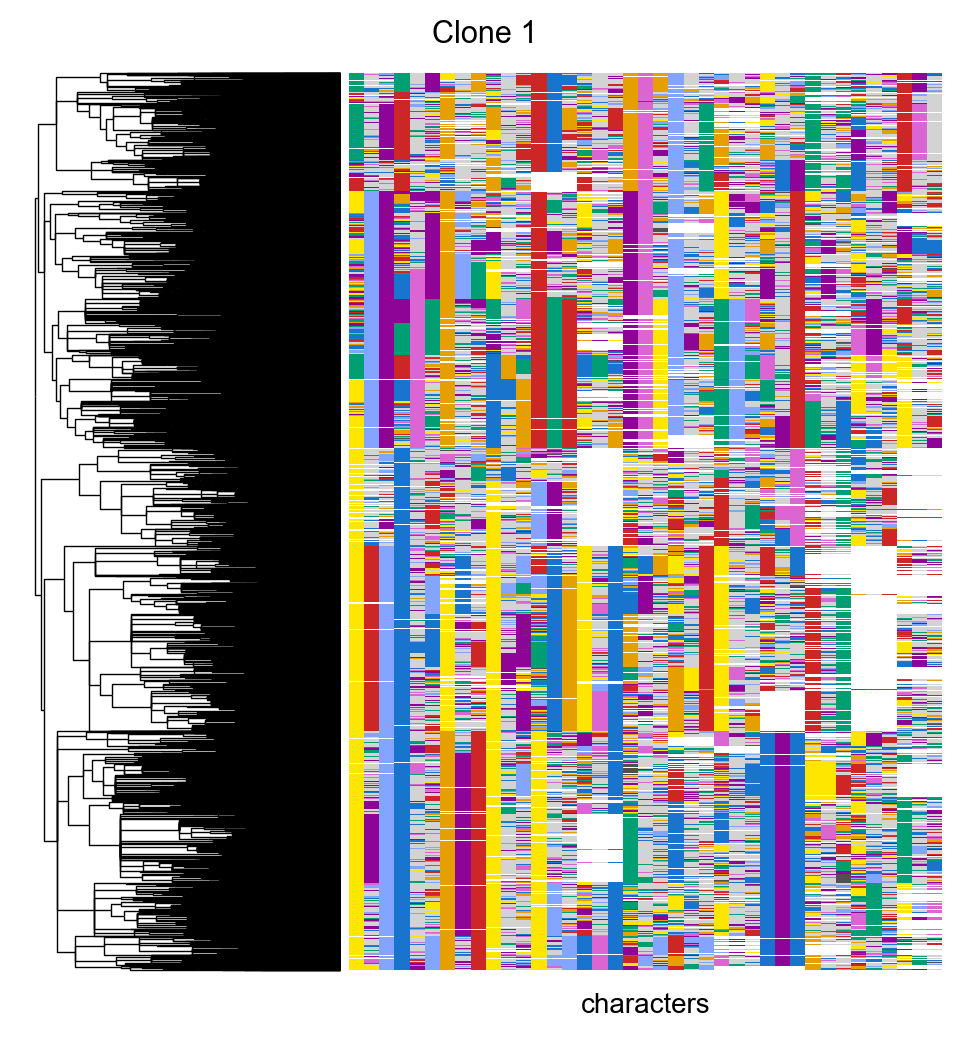

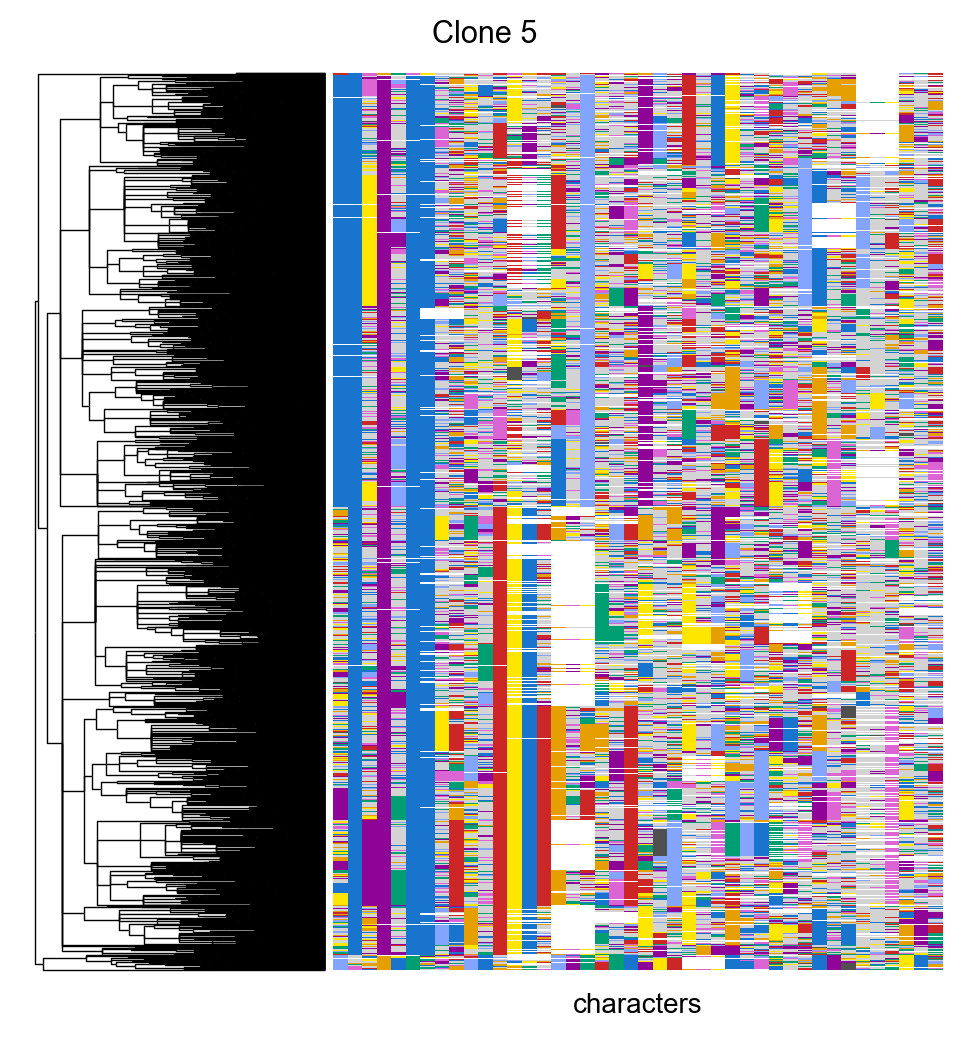

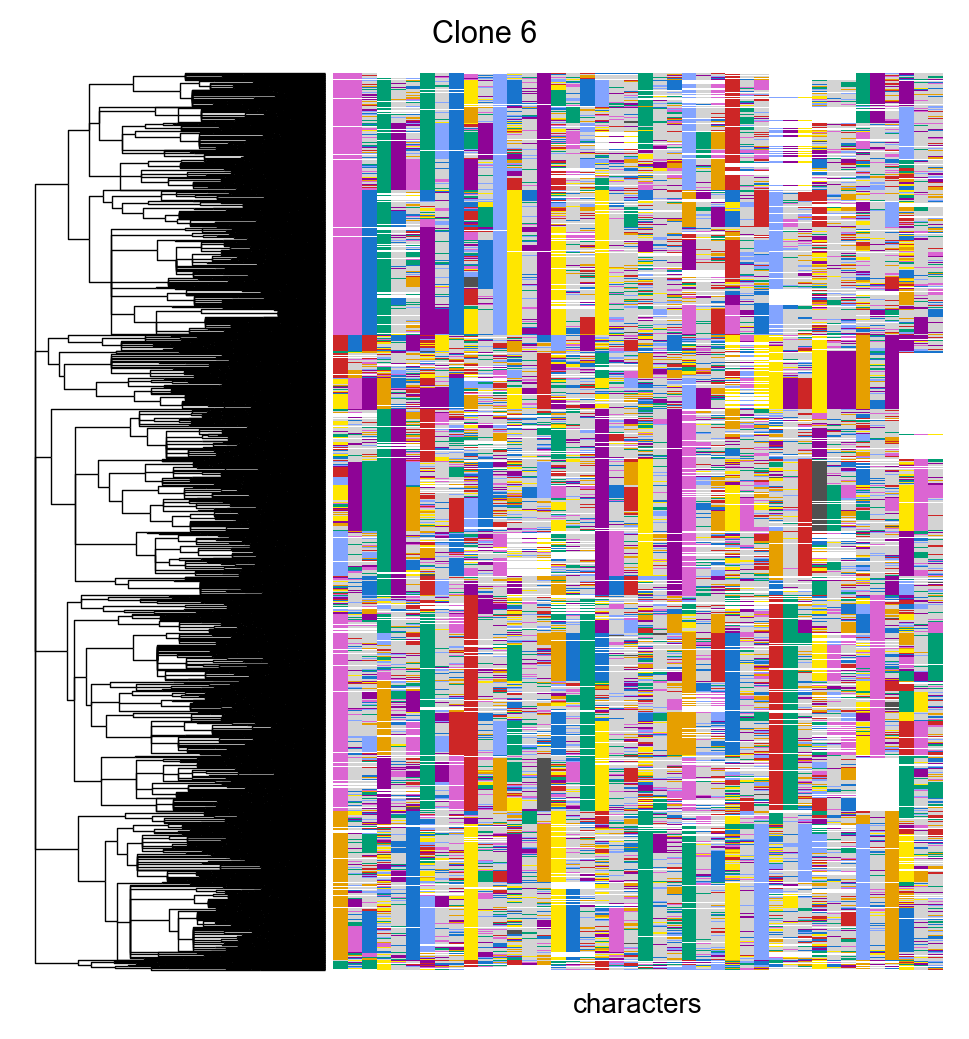

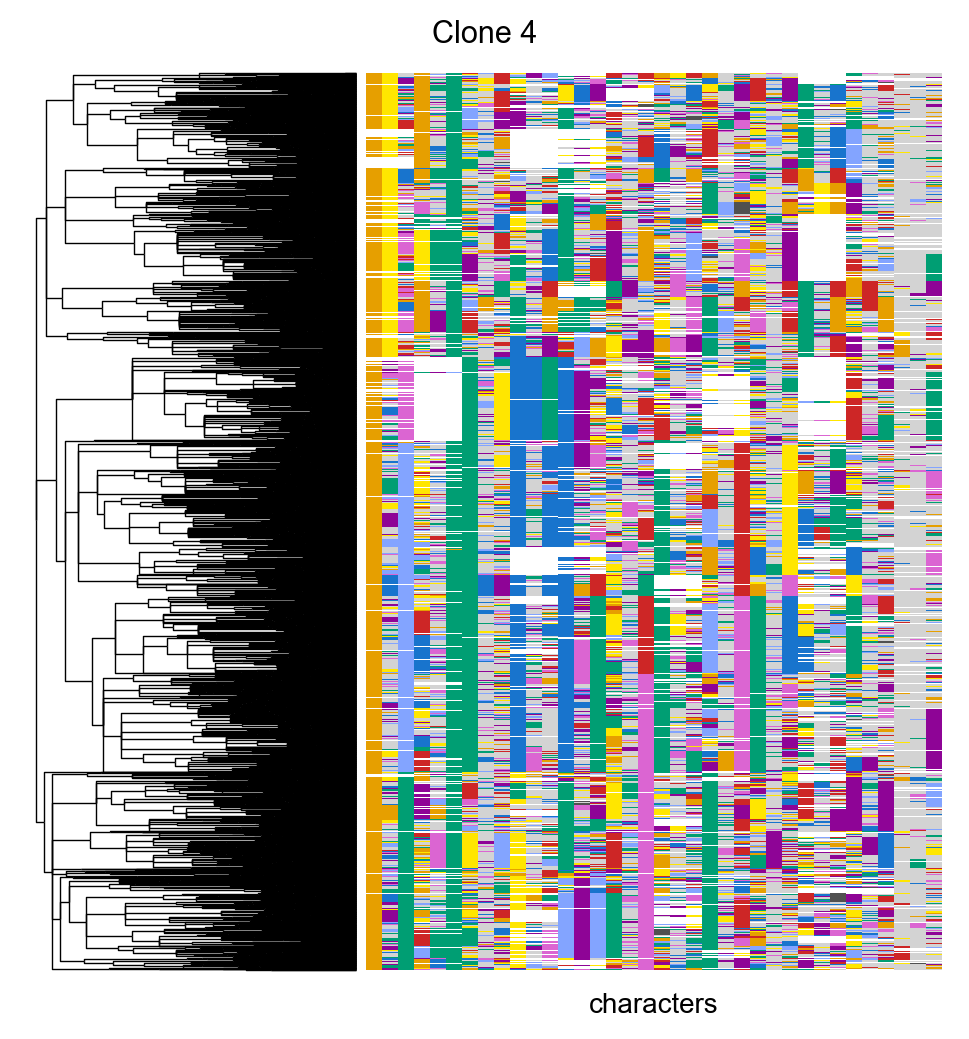

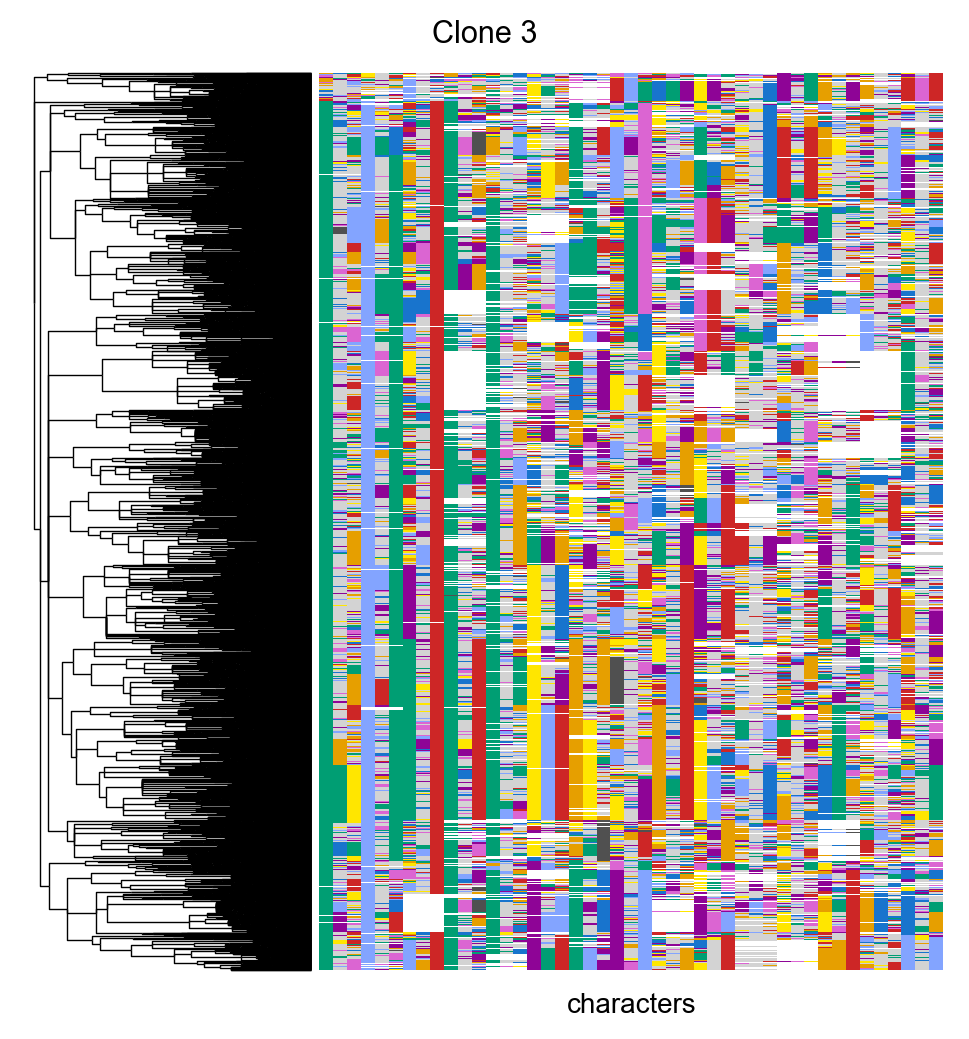

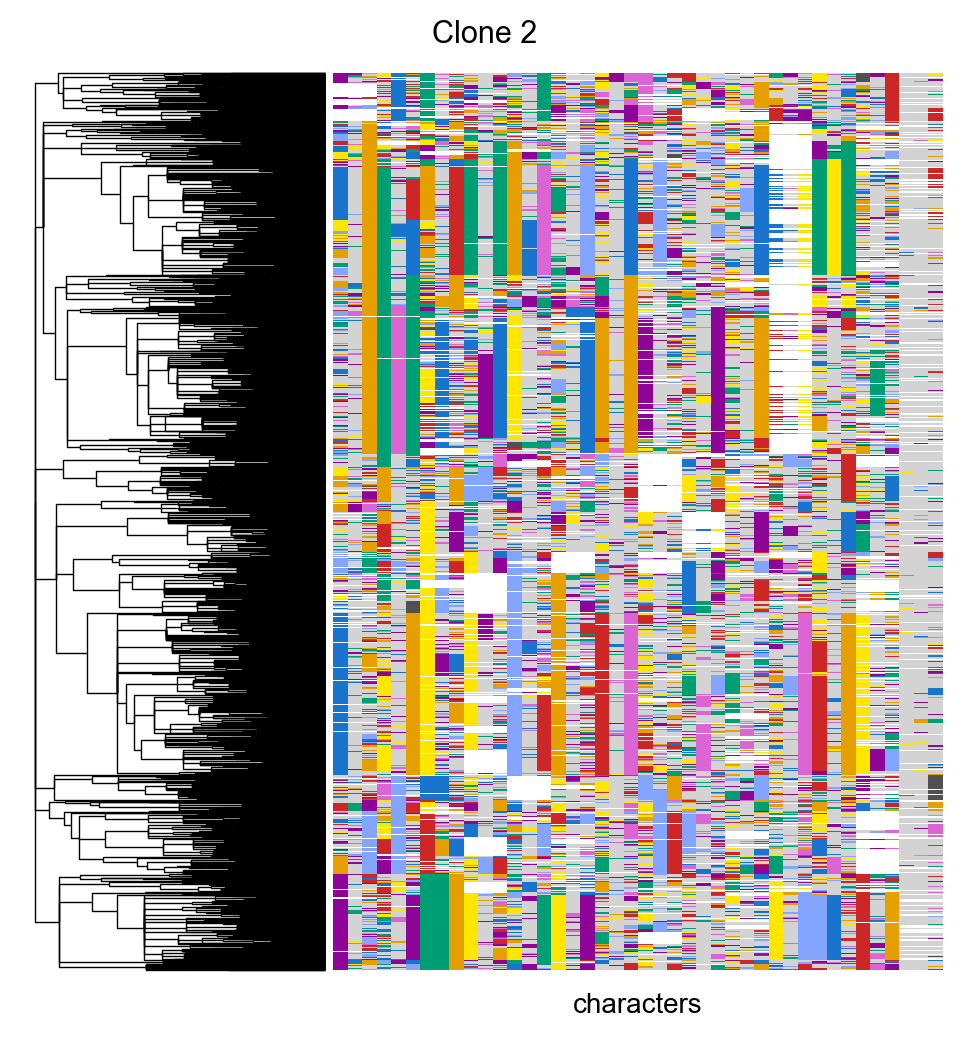

In [75]:
for clone, clone_tdata in clones.items():
    fig,ax = plt.subplots(1,1,figsize = (6,6))
    pycea.pl.tree(clone_tdata,depth_key="time",keys = "characters",
                  cmap = full_edit_cmap,branch_linewidth=.5,ax = ax)
    plt.title(f"Clone {clone}");

## Get barcode clades

Set up

In [76]:
from src.barcode_utils import get_barcode_clades

Get clades that maximize FMI

In [10]:
for clone, clone_tdata in clones.items():
    for barcode in barcode_names.values():
        clades = get_barcode_clades(clone_tdata, barcode).set_index("node")["group"].to_dict()
        nx.set_node_attributes(clone_tdata.obst["tree"],clades,name = f"{barcode}_lca")
        pycea.tl.clades(clone_tdata, clades = clades,key_added=f"{barcode}_clade",depth_key="time")
        pycea.tl.clades(clone_tdata, clades = clades,key_added="combined_clade",depth_key="time",update = True)

## Write data

In [110]:
import scipy as sp
import copy

In [111]:
temp = copy.deepcopy(clones)

In [114]:
clone_tdata

TreeData object with n_obs × n_vars = 9625 × 32288
    obs: 'cellBC', 'sample', 'clone', 'type', 'puro', 'blast', 'tree', 'puro_clade', 'combined_clade', 'blast_clade'
    var: 'mean_counts', 'total_counts'
    obsm: 'characters', 'puro_counts', 'blast_counts'
    obsp: 'character_distances'
    obst: 'tree'

In [115]:
for clone, clone_tdata in clones.items():
    for barcode in barcode_names.values():
        barcode_counts = clone_tdata.obs[["cellBC"]].merge(clone_barcode_counts[barcode][clone],
            left_index = True,right_index = True,how = "left").drop(columns = "cellBC").fillna(0)
        clone_tdata.obsm[f"{barcode}_counts"] = barcode_counts
    del clone_tdata.obsp["character_distances"]
    clone_tdata.write(data_path / f"barcoding_clone_{clone}.h5td")
filtered_alleles.to_csv(data_path / f"barcoding_alleles.csv",index = False)

In [121]:
clone_tdata.obs

,cellBC,sample,clone,type,puro,blast,tree,puro_clade,combined_clade,blast_clade
pool3-AAACCCAAGGCAATGC-1,pool3-AAACCCAAGGCAATGC-1,pool3,2,normal,NaN,51,tree,2,51,51
pool3-AAACCCACAGAGGTAC-1,pool3-AAACCCACAGAGGTAC-1,pool3,2,normal,3,4,tree,3,4,4
pool3-AAACCCATCGTAGGAG-1,pool3-AAACCCATCGTAGGAG-1,pool3,2,normal,NaN,26,tree,NaN,26,26
pool3-AAACGAAAGGAGAGGC-1,pool3-AAACGAAAGGAGAGGC-1,pool3,2,normal,NaN,54,tree,NaN,54,54
pool3-AAACGAACAATTAGGA-1,pool3-AAACGAACAATTAGGA-1,pool3,2,normal,7,22,tree,7,22,22
...,...,...,...,...,...,...,...,...,...,...
pool3-TTTGGTTGTCTCACAA-1,pool3-TTTGGTTGTCTCACAA-1,pool3,2,normal,NaN,11,tree,NaN,11,11
pool3-TTTGGTTTCATTACCT-1,pool3-TTTGGTTTCATTACCT-1,pool3,2,normal,3,4,tree,3,4,4
pool3-TTTGTTGCATTGGATC-1,pool3-TTTGTTGCATTGGATC-1,pool3,2,normal,3,4,tree,3,4,4
pool3-TTTGTTGGTCACTCTC-1,pool3-TTTGTTGGTCACTCTC-1,pool3,2,normal,5,8,tree,5,8,8


<Axes: >

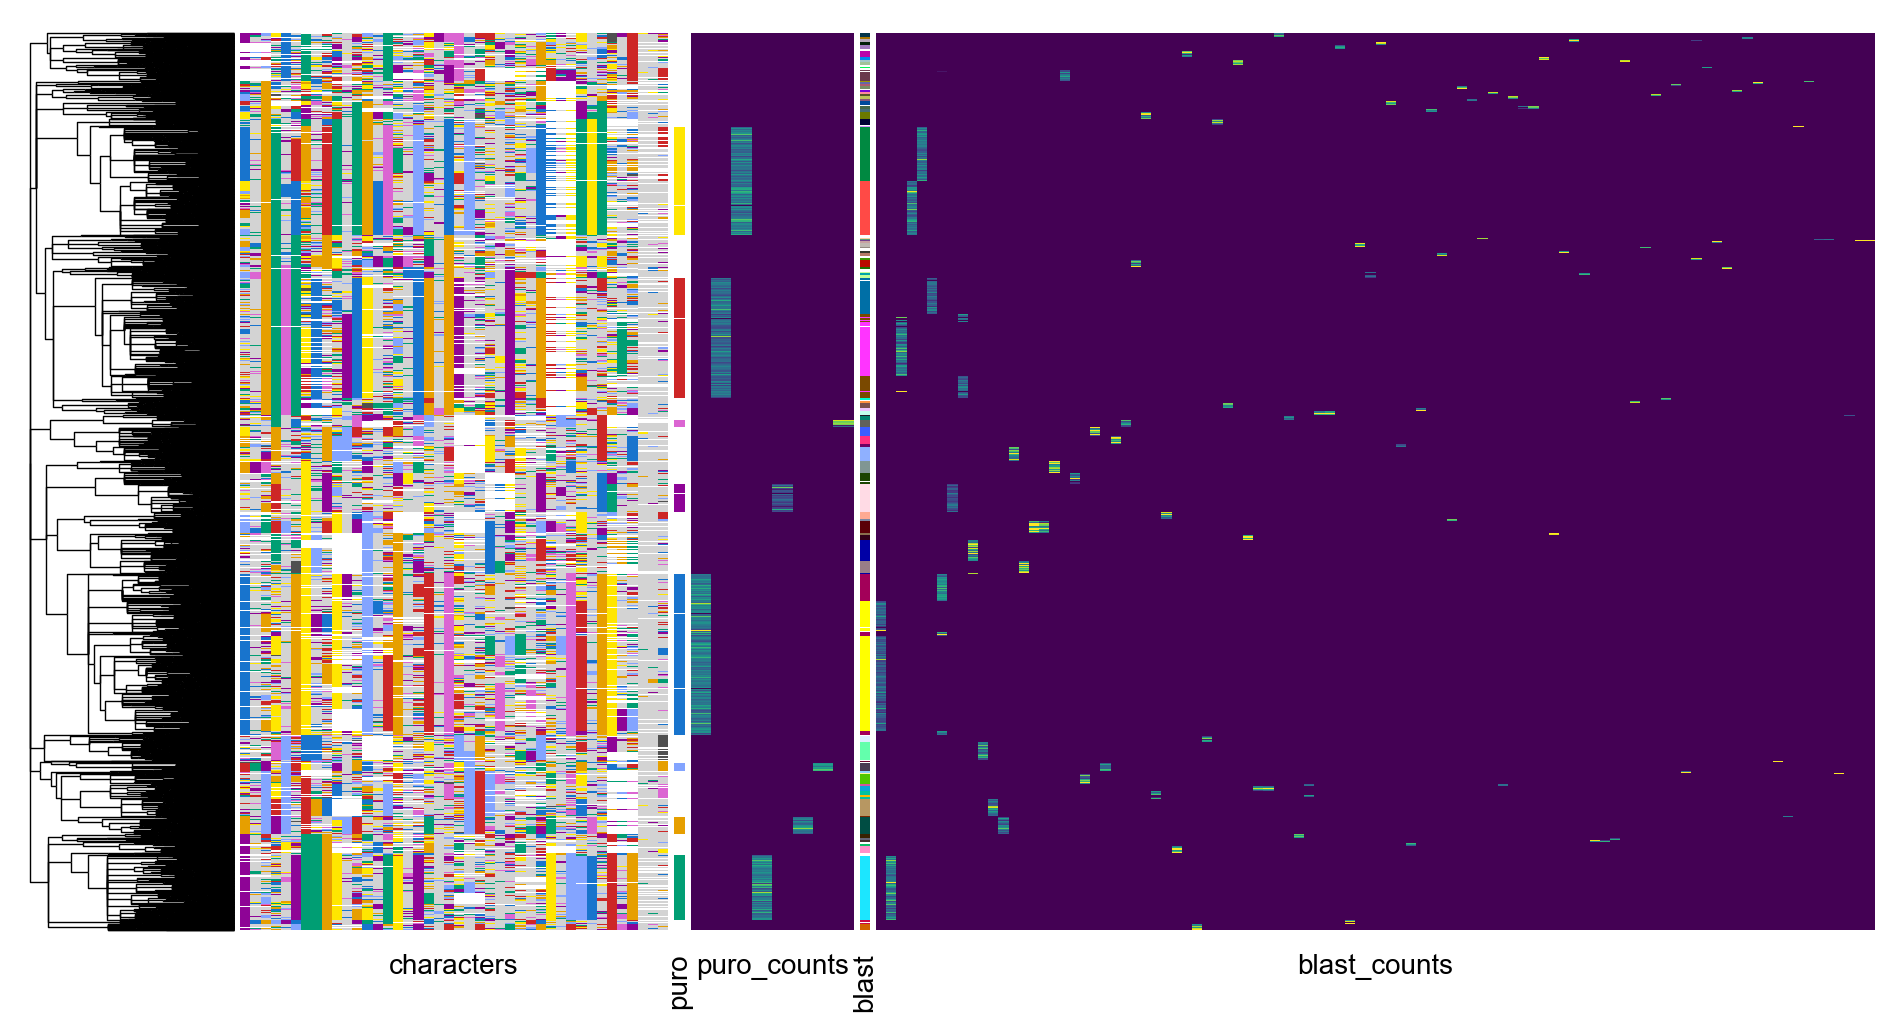

In [132]:
fig,ax = plt.subplots(1,1,figsize = (12,6))
pycea.pl.tree(clone_tdata,depth_key="time",keys = "characters",
                cmap = full_edit_cmap,branch_linewidth=.5,ax = ax)
pycea.pl.annotation(clone_tdata,keys = ["puro"],ax = ax)
pycea.pl.annotation(clone_tdata,keys = ["puro_counts"],ax = ax,width = .1,vmax = 500)
pycea.pl.annotation(clone_tdata,keys = ["blast"],ax = ax)
pycea.pl.annotation(clone_tdata,keys = ["blast_counts"],ax = ax,width = .05,vmax = 500)

In [116]:
clone_tdata

TreeData object with n_obs × n_vars = 3928 × 32288
    obs: 'cellBC', 'sample', 'clone', 'type', 'puro', 'blast', 'tree', 'puro_clade', 'combined_clade', 'blast_clade'
    var: 'mean_counts', 'total_counts'
    obsm: 'characters', 'puro_counts', 'blast_counts'
    obst: 'tree'

In [88]:
clone_tdata = clones["5"].copy()

In [83]:
clone_tdata.obsm["puro_counts"] = clone_barcode_counts["puro"]["5"].loc[clone_tdata.obs["cellBC"],:].values

TreeData object with n_obs × n_vars = 2352 × 32288
    obs: 'cellBC', 'sample', 'clone', 'type', 'puro', 'blast', 'tree', 'puro_clade', 'combined_clade', 'blast_clade'
    var: 'mean_counts', 'total_counts'
    obsm: 'characters'
    obsp: 'character_distances'
    obst: 'tree'

In [100]:
clone_tdata.obs

,cellBC,sample,clone,type,puro,blast,tree,puro_clade,combined_clade,blast_clade
pool2-AAACCCAAGACGAGCT-1,pool2-AAACCCAAGACGAGCT-1,pool2,5,normal,21,107,tree,NaN,107,107
pool2-AAACCCATCCCGTGAG-1,pool2-AAACCCATCCCGTGAG-1,pool2,5,normal,4,9,tree,4,16,16
pool2-AAACGAACAATGGCCC-1,pool2-AAACGAACAATGGCCC-1,pool2,5,normal,37,NaN,tree,37,37,NaN
pool2-AAACGAAGTAAGGTCG-1,pool2-AAACGAAGTAAGGTCG-1,pool2,5,normal,5,NaN,tree,NaN,NaN,NaN
pool2-AAACGAAGTCCAGGTC-1,pool2-AAACGAAGTCCAGGTC-1,pool2,5,normal,15,78,tree,15,78,78
...,...,...,...,...,...,...,...,...,...,...
pool2-TTTGGAGGTTCTGAGT-1,pool2-TTTGGAGGTTCTGAGT-1,pool2,5,normal,22,NaN,tree,22,95,95
pool2-TTTGGAGTCCGGACGT-1,pool2-TTTGGAGTCCGGACGT-1,pool2,5,normal,NaN,43,tree,NaN,43,43
pool2-TTTGGTTAGCTGACCC-1,pool2-TTTGGTTAGCTGACCC-1,pool2,5,normal,4,9,tree,4,16,16
pool2-TTTGTTGAGTGATAGT-1,pool2-TTTGTTGAGTGATAGT-1,pool2,5,normal,11,8,tree,11,8,8


In [106]:
barcode_counts = clone_tdata.obs[["cellBC"]].merge(clone_barcode_counts["puro"]["5"],
            left_index = True,right_index = True,how = "left").drop(columns = "cellBC").fillna(0)
barcode_counts = sp.sparse.csr_matrix(barcode_counts.values)

In [107]:
barcode_counts

<2352x40 sparse matrix of type '<class 'numpy.float64'>'
	with 2516 stored elements in Compressed Sparse Row format>

In [108]:
barcode_counts.rows

AttributeError: 'csr_matrix' object has no attribute 'rows'

In [105]:
(barcode_counts.index == clone_tdata.obs.index).mean()

1.0

In [91]:
clone_barcode_counts["puro"]["5"].loc[clone_tdata.obs["cellBC"],:].values

KeyError: "['pool2-AAAGAACCAGTAGTTC-1', 'pool2-AAAGGATTCCTGGCTT-1', 'pool2-AAAGGGCAGGGCCCTT-1', 'pool2-AAATGGATCAGACAAA-1', 'pool2-AACACACCAGAGTTCT-1', 'pool2-AACAGGGGTCACGCTG-1', 'pool2-AACCAACCAGAATTCC-1', 'pool2-AACCAACCAGCATCTA-1', 'pool2-AACCTTTCATCAGTCA-1', 'pool2-AAGAACATCCGATCTC-1', 'pool2-AAGACTCTCTGCTTAT-1', 'pool2-AAGCCATAGAAATTCG-1', 'pool2-AAGCGTTAGGCGTCCT-1', 'pool2-AAGCGTTCAAGATGTA-1', 'pool2-AAGCGTTTCTATCACT-1', 'pool2-AAGGAATGTGGTTCTA-1', 'pool2-AAGGTAAAGAGCACTG-1', 'pool2-AAGTTCGTCACAGAGG-1', 'pool2-AATCACGCACCAGCTG-1', 'pool2-AATGCCAAGCCTAACT-1', 'pool2-AATGCCATCACCACAA-1', 'pool2-AATGGAAAGAGGTCAC-1', 'pool2-ACAAAGATCGACGCGT-1', 'pool2-ACAACCAAGGGTAGCT-1', 'pool2-ACACTGATCACCTGTC-1', 'pool2-ACAGCCGAGTTGTAAG-1', 'pool2-ACATTTCAGTTAGTGA-1', 'pool2-ACATTTCTCGAGAAGC-1', 'pool2-ACCCAAAAGGTGCGAT-1', 'pool2-ACCCAAACATGACTGT-1', 'pool2-ACCCTCAGTAGCACAG-1', 'pool2-ACCTGAAAGATGAAGG-1', 'pool2-ACGATGTTCTGCCCTA-1', 'pool2-ACGCACGTCACGTAGT-1', 'pool2-ACGGAAGTCTGTACAG-1', 'pool2-ACGTACAAGCCTGAGA-1', 'pool2-ACGTCCTCACAGTACT-1', 'pool2-ACTATCTAGGTACATA-1', 'pool2-ACTATTCGTTTGGCTA-1', 'pool2-ACTCCCACAGCACCCA-1', 'pool2-ACTTAGGGTCATGGCC-1', 'pool2-ACTTAGGGTCTACGAT-1', 'pool2-ACTTAGGTCGTCCTCA-1', 'pool2-ACTTTGTAGTGTTGTC-1', 'pool2-AGACAAAAGACCAAAT-1', 'pool2-AGACACTTCAGTCTTT-1', 'pool2-AGACAGGTCCACCCTA-1', 'pool2-AGACCATCAAAGGGTC-1', 'pool2-AGACTCAGTATGGAGC-1', 'pool2-AGAGAATTCATCGACA-1', 'pool2-AGAGAGCGTTAAGCAA-1', 'pool2-AGAGCAGGTTGCGGAA-1', 'pool2-AGATCGTTCTTTCAGT-1', 'pool2-AGCATCAGTCATCGCG-1', 'pool2-AGCCACGAGGATTTAG-1', 'pool2-AGCCACGCATAGTCAC-1', 'pool2-AGCGATTTCTTCCGTG-1', 'pool2-AGCTACAGTACTCGTA-1', 'pool2-AGCTTCCCATTCTTCA-1', 'pool2-AGGAATAGTGTGTTTG-1', 'pool2-AGGAGGTAGGCCCAAA-1', 'pool2-AGGATAAGTGTTGAGG-1', 'pool2-AGGTCATGTGCGGCTT-1', 'pool2-AGGTTACCATCGGAGA-1', 'pool2-AGGTTACTCACGAGGA-1', 'pool2-AGTAGCTCACATAACC-1', 'pool2-AGTCATGCAGCAGAAC-1', 'pool2-AGTCTCCAGTTCTCTT-1', 'pool2-AGTTAGCGTCTTCGAA-1', 'pool2-AGTTAGCTCTCAAAGC-1', 'pool2-ATACCTTTCCCGAGTG-1', 'pool2-ATACTTCCAAGTGCTT-1', 'pool2-ATACTTCTCATTTGTC-1', 'pool2-ATAGAGAAGCGAGGAG-1', 'pool2-ATAGAGATCCTGTAGA-1', 'pool2-ATAGGCTTCAGAGTTC-1', 'pool2-ATCAGGTGTAGCTGTT-1', 'pool2-ATCCATTCAGGTCCGT-1', 'pool2-ATCCCTGCAATAACGA-1', 'pool2-ATCGCCTTCATACGAC-1', 'pool2-ATCGGATAGAGTCACG-1', 'pool2-ATCGTGACATCTAGAC-1', 'pool2-ATGAAAGGTTTCGTAG-1', 'pool2-ATGACCAGTCGTTTCC-1', 'pool2-ATGACCATCATGGCCG-1', 'pool2-ATGGAGGAGAGCCGAT-1', 'pool2-ATGGAGGTCCCATGGG-1', 'pool2-ATGGATCTCTCTCCGA-1', 'pool2-ATGGGAGGTTACCTGA-1', 'pool2-ATGGTTGAGACATACA-1', 'pool2-ATGTCCCTCATCTACT-1', 'pool2-ATGTCCCTCTTCTGGC-1', 'pool2-ATTATCCGTCACAATC-1', 'pool2-ATTCAGGGTTTACGAC-1', 'pool2-ATTCAGGTCGCTTACC-1', 'pool2-ATTCATCAGGCACTAG-1', 'pool2-ATTCCTATCTAATTCC-1', 'pool2-ATTCGTTCAGACCTAT-1', 'pool2-ATTCTACGTAACTGCT-1', 'pool2-ATTGTTCCAGCAGTCC-1', 'pool2-ATTGTTCCATCCCGTT-1', 'pool2-CAATTTCTCGGCTGGT-1', 'pool2-CACAACAGTCGGCCTA-1', 'pool2-CACAACATCAACGAGG-1', 'pool2-CACACAAAGTCACAGG-1', 'pool2-CACAGATCAAATTGGA-1', 'pool2-CACGGGTAGTGATTCC-1', 'pool2-CACGTTCAGACTTCCA-1', 'pool2-CACTGAAGTTCGGCCA-1', 'pool2-CACTTCGCACAGAGCA-1', 'pool2-CAGCAATTCCTTCTTC-1', 'pool2-CAGCAGCCATGAATCC-1', 'pool2-CAGCCAGGTGCTGTCG-1', 'pool2-CAGCCAGTCATACAGC-1', 'pool2-CAGTTCCTCCGTCACT-1', 'pool2-CATCGGGAGTTCTACG-1', 'pool2-CATGCAACAACCGTGC-1', 'pool2-CATGCAAGTTCCCACT-1', 'pool2-CATGCGGCAAGTACCT-1', 'pool2-CATTGCCGTAATACCC-1', 'pool2-CATTTCATCCAAAGGG-1', 'pool2-CATTTCATCCTCACCA-1', 'pool2-CCAATGAAGGAACGAA-1', 'pool2-CCAATGACACAGCATT-1', 'pool2-CCAATGATCCTGTTAT-1', 'pool2-CCACCATGTGGTACAG-1', 'pool2-CCACGAGCAGCAGATG-1', 'pool2-CCACTTGGTGGCTTAT-1', 'pool2-CCCGGAAAGGTCGTCC-1', 'pool2-CCCGGAAGTGGTCTTA-1', 'pool2-CCCTAACAGTGCACCC-1', 'pool2-CCCTCAAGTGCGAGTA-1', 'pool2-CCGATCTCATGCAGGA-1', 'pool2-CCGATCTTCAAAGGTA-1', 'pool2-CCGATGGTCTAGCCTC-1', 'pool2-CCGGTAGTCAGCTGAT-1', 'pool2-CCGTGAGCACGGTGTC-1', 'pool2-CCTAAGACAGACGGAT-1', 'pool2-CCTCAACTCTCAATCT-1', 'pool2-CCTCACAAGAGGGTGG-1', 'pool2-CGAAGTTAGCATAGGC-1', 'pool2-CGACAGCTCTGCTAGA-1', 'pool2-CGAGGAATCCGCGAGT-1', 'pool2-CGAGGCTTCGCCGAGT-1', 'pool2-CGAGTTAAGCGTGAAC-1', 'pool2-CGATGGCAGCATGTTC-1', 'pool2-CGCAGGTGTAAGCTCT-1', 'pool2-CGCAGGTTCCTACGAA-1', 'pool2-CGGAGAAGTACGATTC-1', 'pool2-CGGCAGTTCTTTACAC-1', 'pool2-CGTAGTACAGTCTTCC-1', 'pool2-CGTCAAACAAAGCTAA-1', 'pool2-CGTCAAACATACAGCT-1', 'pool2-CGTCCATAGATAGTGT-1', 'pool2-CGTCCATAGTAATTGG-1', 'pool2-CGTGAATAGGATTCCT-1', 'pool2-CTAACTTTCGAGAGCA-1', 'pool2-CTACGGGCATACAGCT-1', 'pool2-CTACGGGTCGGCCCAA-1', 'pool2-CTACTATAGCATGATA-1', 'pool2-CTAGGTAGTAACCAGG-1', 'pool2-CTATAGGGTCTACGTA-1', 'pool2-CTCAACCGTCGGTGAA-1', 'pool2-CTCAAGAGTTTAGACC-1', 'pool2-CTCAAGATCGTAACTG-1', 'pool2-CTCAGAAGTCAAGCCC-1', 'pool2-CTCAGGGGTCGTTATG-1', 'pool2-CTCATCGAGGGACTGT-1', 'pool2-CTCATGCTCTAGACAC-1', 'pool2-CTCCCAATCATTTCCA-1', 'pool2-CTCTCAGGTCAGTCTA-1', 'pool2-CTCTCGAGTATGAAGT-1', 'pool2-CTGAGGCGTTCACGAT-1', 'pool2-CTGAGGCTCCAAAGGG-1', 'pool2-CTGATCCAGACTCAAA-1', 'pool2-CTGATCCAGTACGTCT-1', 'pool2-CTGCCATCAATCTAGC-1', 'pool2-CTGCCTAAGTCGAAAT-1', 'pool2-CTGCGAGGTACCGTGC-1', 'pool2-CTGCTCAAGGATCACG-1', 'pool2-CTGCTCATCTCGGCTT-1', 'pool2-CTGGCAGAGCTCGACC-1', 'pool2-CTGTATTGTTCGTAAC-1', 'pool2-CTGTCGTTCTCTGAGA-1', 'pool2-GAAGGGTCACACGGTC-1', 'pool2-GAATAGAGTCAGCTTA-1', 'pool2-GACTATGAGTTCTACG-1', 'pool2-GAGACTTCACTGCACG-1', 'pool2-GAGAGGTGTCAAAGAT-1', 'pool2-GAGCCTGCAGTCAGCC-1', 'pool2-GAGGCAAAGCCTCACG-1', 'pool2-GAGGCCTAGGCACTAG-1', 'pool2-GAGTCATTCCACAAGT-1', 'pool2-GATAGCTCATTCCTAT-1', 'pool2-GATCACATCCAAACCA-1', 'pool2-GATCAGTAGTTACTCG-1', 'pool2-GATCAGTCAAATTGCC-1', 'pool2-GATCAGTGTCACGCTG-1', 'pool2-GATCAGTTCCCGATCT-1', 'pool2-GATCAGTTCTAGGCAT-1', 'pool2-GATCATGAGTATTAGG-1', 'pool2-GATGTTGAGCCTAACT-1', 'pool2-GATTCGAGTCTTGCGG-1', 'pool2-GATTCGAGTTTGATCG-1', 'pool2-GATTCTTGTACGATGG-1', 'pool2-GATTGGTGTAGGCTGA-1', 'pool2-GATTTCTAGAGCAGAA-1', 'pool2-GATTTCTAGCCTCATA-1', 'pool2-GCACGTGGTAATGTGA-1', 'pool2-GCACTAAAGTCATCCA-1', 'pool2-GCAGCCAAGGGTCAAC-1', 'pool2-GCATCGGGTGTTCCTC-1', 'pool2-GCGAGAACACCTGAAT-1', 'pool2-GCGAGAACACGTACAT-1', 'pool2-GCGAGAAGTTACCCAA-1', 'pool2-GCTCAAATCAAGGCTT-1', 'pool2-GCTGAATTCTTCTTCC-1', 'pool2-GCTGGGTAGCTCCGAC-1', 'pool2-GCTGGGTCATGGGTTT-1', 'pool2-GCTTCACTCATTGTTC-1', 'pool2-GCTTGGGGTTTGGCTA-1', 'pool2-GGAATGGGTTTCGTTT-1', 'pool2-GGAGAACGTTAATCGC-1', 'pool2-GGAGAACTCTTCGCTG-1', 'pool2-GGAGATGTCATCTCTA-1', 'pool2-GGATCTAGTAGTTAGA-1', 'pool2-GGATCTAGTTTGGAAA-1', 'pool2-GGCTTGGAGGATTACA-1', 'pool2-GGGAGTACACCGCTGA-1', 'pool2-GGGATGACAATGGCCC-1', 'pool2-GGGCTACAGGCTGGAT-1', 'pool2-GGGCTCATCACTGATG-1', 'pool2-GGGTAGATCCATGAGT-1', 'pool2-GGGTCACCACGAAAGC-1', 'pool2-GGTGAAGGTCACTCTC-1', 'pool2-GGTGATTAGAACCGCA-1', 'pool2-GGTGGCTCACACGTGC-1', 'pool2-GTAACCAGTGGGACAT-1', 'pool2-GTAATCGCATCGGAGA-1', 'pool2-GTAGATCAGCTCGAAG-1', 'pool2-GTAGGAGGTTATGGTC-1', 'pool2-GTCAAACTCACATTGG-1', 'pool2-GTCAAGTCACAGAGAC-1', 'pool2-GTCAAGTCACGGCCAT-1', 'pool2-GTCACTCCAGGATGAC-1', 'pool2-GTCCACTGTGCTCGTG-1', 'pool2-GTCGCGAAGAGATCGC-1', 'pool2-GTCGTAACAAAGAACT-1', 'pool2-GTCTAGATCGAGAATA-1', 'pool2-GTGGCGTCAAAGAGTT-1', 'pool2-GTGTAACGTCAACGCC-1', 'pool2-GTGTTCCAGTTTGTCG-1', 'pool2-GTTACCCCACCATAAC-1', 'pool2-GTTATGGCAAACCATC-1', 'pool2-GTTCATTCATCGATAC-1', 'pool2-TAACACGAGCGGGTTA-1', 'pool2-TACACCCCACGACAAG-1', 'pool2-TACACCCTCCACAAGT-1', 'pool2-TACCCGTCATGTAACC-1', 'pool2-TACGGGCTCTCGCCTA-1', 'pool2-TACGTCCCAGCAGTCC-1', 'pool2-TACGTCCCATTCTCCG-1', 'pool2-TACTGCCTCGACGACC-1', 'pool2-TAGACTGAGGATACAT-1', 'pool2-TAGATCGGTCACTGAT-1', 'pool2-TAGGTTGCACCACATA-1', 'pool2-TAGGTTGCAGTTAGGG-1', 'pool2-TATACCTAGGAGTATT-1', 'pool2-TATATCCAGACTTCAC-1', 'pool2-TATCGCCTCGACGCGT-1', 'pool2-TCACAAGGTTGCCATA-1', 'pool2-TCACATTAGGTAAGTT-1', 'pool2-TCACTCGGTAAGCGGT-1', 'pool2-TCAGCCTAGTCATAGA-1', 'pool2-TCAGGGCCACTCTGCT-1', 'pool2-TCATGAGAGTGCACTT-1', 'pool2-TCATTGTGTCTCACGG-1', 'pool2-TCCCACACAGGTTCAT-1', 'pool2-TCCCATGCATCTCATT-1', 'pool2-TCCTAATTCTATCGTT-1', 'pool2-TCCTCCCAGCTCATAC-1', 'pool2-TCCTCGAAGGTGCTAG-1', 'pool2-TCCTTTCAGACGTCCC-1', 'pool2-TCCTTTCTCTACCTTA-1', 'pool2-TCGATTTTCCGTATAG-1', 'pool2-TCGCAGGAGTGCGACA-1', 'pool2-TCGTCCATCATACAGC-1', 'pool2-TCTACCGAGGCTCCCA-1', 'pool2-TCTACCGAGTGCGACA-1', 'pool2-TCTCTGGTCTGTCAGA-1', 'pool2-TCTGCCAAGACCTTTG-1', 'pool2-TCTTAGTCACTGCACG-1', 'pool2-TGACCCTAGAGTTGAT-1', 'pool2-TGACCCTAGTACCGGA-1', 'pool2-TGAGCGCCAAGACTGG-1', 'pool2-TGCGGGTGTATACAGA-1', 'pool2-TGCTCCAGTAAGGCCA-1', 'pool2-TGCTTCGAGAGAATCT-1', 'pool2-TGCTTGCTCTCATTGT-1', 'pool2-TGGATCATCAGTGTGT-1', 'pool2-TGGCGTGAGACATACA-1', 'pool2-TGGGAGAAGCCGCTTG-1', 'pool2-TGGGAGAGTAACCCGC-1', 'pool2-TGGGAGAGTGCAACAG-1', 'pool2-TGGGATTGTGTGTCGC-1', 'pool2-TGGGCTGGTGGATGAC-1', 'pool2-TGGGTTAAGGACTGGT-1', 'pool2-TGGGTTACACAAACGG-1', 'pool2-TGGTGATTCGGTGAAG-1', 'pool2-TGGTTAGTCTGAATGC-1', 'pool2-TGTAAGCTCTCACCCA-1', 'pool2-TGTAGACGTGATAGTA-1', 'pool2-TGTCCTGGTGATGTAA-1', 'pool2-TGTTACTCAAGAGTTA-1', 'pool2-TGTTCATAGCCTGAAG-1', 'pool2-TGTTGGATCTGGTGGC-1', 'pool2-TTACCATAGGTTAGTA-1', 'pool2-TTACCGCTCCCTCAAC-1', 'pool2-TTACCGCTCCCTCTCC-1', 'pool2-TTACTGTTCATCGCTC-1', 'pool2-TTAGGCAAGTCACTCA-1', 'pool2-TTATTGCTCGTAGGAG-1', 'pool2-TTCAATCAGGGTTAGC-1', 'pool2-TTCACCGGTTCCATTT-1', 'pool2-TTCATTGGTTATGTGC-1', 'pool2-TTCTAACTCATAAGGA-1', 'pool2-TTCTAGTCACGGCCAT-1', 'pool2-TTCTCTCGTCCTGAAT-1', 'pool2-TTGAACGGTAACCCTA-1', 'pool2-TTGCTGCCACTACCGG-1', 'pool2-TTGGGATCATTAGGCT-1', 'pool2-TTGTGGACAATGGCAG-1', 'pool2-TTTACCACAGCCTTCT-1', 'pool2-TTTACCATCCGAACGC-1', 'pool2-TTTCATGAGCACTAGG-1', 'pool2-TTTGACTCAAGACCGA-1', 'pool2-TTTGGAGGTCTTTATC-1', 'pool2-TTTGGAGTCCGGACGT-1'] not in index"

In [112]:
clone_barcode_counts["puro"]["5"]

intBC,TTGCAATTGA,CTAGCAATTA,AACCGCAAAT,GTATCTGAGT,ACCGAATTTC,ACACCTTCGT,AATCCTACGC,CCTGTATACA,CTCCCATAAT,TCGTGCGAAT,...,ACCTTTAATA,ACGGCTGGTA,GTTTAGTTGC,GGTTTCGAGG,ACTTGGCGAC,TGATGCTTTG,GTCGTTACAT,CCAAGTCTAT,GTTTAGGGGA,CAACTGTACA
cellBC,,,,,,,,,,,,,,,,,,,,,
pool2-AAACCCAAGACGAGCT-1,175.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pool2-AAACCCATCCCGTGAG-1,0.0,0.0,0.0,253.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pool2-AAACGAACAATGGCCC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0
pool2-AAACGAAGTAAGGTCG-1,0.0,0.0,0.0,0.0,188.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pool2-AAACGAAGTCCAGGTC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pool2-TTTGATCGTATCGCGC-1,0.0,0.0,147.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pool2-TTTGGAGGTTCTGAGT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pool2-TTTGGTTAGCTGACCC-1,0.0,0.0,0.0,192.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [89]:
clone_barcode_counts


{'puro': {'1': intBC                     ATTTATGATA  CTAATACTTG  TTATGTAATC  TCCGACTGAC  \
  cellBC                                                                     
  pool1-AAACCCAAGCACGATG-1         0.0       442.0         0.0         0.0   
  pool1-AAACCCAAGGTCACCC-1         0.0         0.0         0.0         0.0   
  pool1-AAACCCACACCCATAA-1         0.0         0.0         0.0         0.0   
  pool1-AAACCCACATGACGTT-1         0.0         0.0         0.0         0.0   
  pool1-AAACCCAGTTCGGTCG-1         0.0         0.0         0.0         0.0   
  ...                              ...         ...         ...         ...   
  pool1-TTTGTTGCAGAGACTG-1         0.0         0.0         0.0         0.0   
  pool1-TTTGTTGCAGATCACT-1         0.0         0.0         0.0         0.0   
  pool1-TTTGTTGTCATATGGC-1         0.0         0.0         0.0         0.0   
  pool1-TTTGTTGTCTGCTTAT-1         0.0         0.0       165.0       191.0   
  pool1-TTTGTTGTCTTACCAT-1         0.0         0.0 

In [80]:
clone_tdata

TreeData object with n_obs × n_vars = 3928 × 32288
    obs: 'cellBC', 'sample', 'clone', 'type', 'puro', 'blast', 'tree', 'puro_clade', 'combined_clade', 'blast_clade'
    var: 'mean_counts', 'total_counts'
    obsm: 'characters'
    obsp: 'character_distances'
    obst: 'tree'

In [81]:
clone_counts

intBC,GTATAAGACA,TTAGCTGTAT,TAATTCGATT,CGTCGACTTG,TGTTATAGCA,GTGATTATCA,CTACTTGTCC,GTTTTACAAC,AAATGTCCTA,AGTGAGCCAC,...,GGTGTAGACG,TGTGACGAGC,TGAGTGCTAA,GTTAACATCA,GGTAATGTAC,CGCATTTCGA,CGGCTTATTA,GGGGTCCTGC,CACACTTACG,GAGCTAAACG
cellBC,,,,,,,,,,,,,,,,,,,,,
pool3-AAACCCAAGGCAATGC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pool3-AAACCCACAGAGGTAC-1,0.0,0.0,0.0,178.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pool3-AAACCCATCGTAGGAG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pool3-AAACGAAAGGAGAGGC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pool3-AAACGAACAATTAGGA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pool3-TTTGGTTGTCTCACAA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pool3-TTTGGTTTCATTACCT-1,0.0,0.0,0.0,191.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pool3-TTTGTTGCATTGGATC-1,0.0,0.0,0.0,245.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
